# Build validation table of ICESat-2/ATLAS transects at field sites

with field observations at ground level (TODO) and from UAV 

https://docs.google.com/spreadsheets/d/1jqP0K0LZmswK4ZZNU6BxKYgjaBZM0HRkUrWS1QFLvIE/edit?gid=0#gid=0  

could be used for manuscript:
https://docs.google.com/document/d/1uj9-xlLTJK1xeGvzIEHvNNnquXYMUNsBDB30a3HhlOc/edit?usp=sharing

#### Workflow:  
+ `code/above-shrubs/notebooks/icesat2_atl03_atl08_class_map_sewardpen.ipynb`
+ `code/above-shrubs/notebooks/field_analysis_build_table.ipynb`
+ `code/above-shrubs/notebooks/field_analysis_plotting_v3.ipynb`
+ `code/above-shrubs/notebooks/field_transect_plots.ipynb`

| Author | Affiliation | Date |
| --- | --- | --- |
| Paul Montesano, PhD | Innovation Lab ; NASA Goddard Space Flight Center | Sept. 2024 |

In [2]:
import os
import pandas as pd
import geopandas as gpd
import glob
import rasterio
import pyproj
import matplotlib.pyplot as plt
import warnings
import folium
from folium import plugins
import fiona
import numpy as np
from basemaplib import *

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_3043811/4279244517.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /app/jupyter/ilab/jupyter-lab/prod/li

In [3]:
import plotnine
from plotnine import *

In [4]:
EXPEDITION_ID = 'sewardpen2024'
OUTDIR = f'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/{EXPEDITION_ID}'
OUTDIR

'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024'

In [5]:
sewpen_fielddata_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/sew_pen_field_data_2024.gpkg'
field_ref_gdf = gpd.read_file(sewpen_fielddata_fn, layer=0) # points w hts from lines from uas
field_ref_gdf['site'] = field_ref_gdf['site'].str.lower()

In [6]:
field_ref_gdf.head()

parent_id        site line_id  point_id  child_id point_distance_m  \
0  747fe077  council_01      01       1.0  890dd23d                2   
1  747fe077  council_01      01       2.0  8c6deb6c                4   
2  747fe077  council_01      01       3.0  087022c1                6   
3  747fe077  council_01      01       4.0  f2e76519                8   
4  747fe077  council_01      01       5.0  cb9f1f25               10   

  species_top_hit  height_cm_30cm species_30cm  height_cm_200cm species_200cm  \
0          salala           174.0       salala            204.0        salala   
1          salala           142.0       salala            225.0        salala   
2          salala           189.0       salala            368.0        salala   
3          salala           273.0       salala            428.0        salala   
4          salala           371.0      salpul1            394.0        salala   

  species_top_hit_agg    species_30cm_agg species_200cm_agg  \
0     Feltleaf willow     Feltleaf willow   Feltleaf willow   
1     Feltleaf willow     Feltleaf willow   Feltleaf willow   
2     Feltleaf willow     Feltleaf willow   Feltleaf willow   
3     Feltleaf willow     Feltleaf willow   Feltleaf willow   
4     Feltleaf willow  Diamondleaf willow   Feltleaf willow   

  species_top_hit_orig species_30cm_orig species_200cm_orig  \
0               salala            salala             salala   
1               salala            salala             salala   
2               salala            salala             salala   
3               salala            salala             salala   
4               salala           salpul1             salala   

             point_datetime          point_location  \
0 2024-08-12 12:01:01+00:00  64.696942, -164.187048   
1 2024-08-12 12:01:46+00:00  64.696947, -164.187052   
2 2024-08-12 12:02:44+00:00  64.696869, -164.187053   
3 2024-08-12 12:03:32+00:00  64.696867, -164.187071   
4 2024-08-12 12:04:21+00:00  64.696797, -164.187105   

                      geometry  
0  POINT (-164.18714 64.69692)  
1  POINT (-164.18714 64.69690)  
2  POINT (-164.18715 64.69689)  
3  POINT (-164.18715 64.69687)  
4  POINT (-164.18715 64.69685)

In [7]:
field_ref_gdf_list = []
for layername in fiona.listlayers(sewpen_fielddata_fn):
    print(layername)
    field_ref_gdf_list.append(gpd.read_file(sewpen_fielddata_fn, layer=layername))

sew_pen_2024_points_wHgts_from_lines_from_uas_rgb_v20240821
sew_pen_2024_lines_from_uas_rgb_v20240821
sew_pen_2024_geotagged_photos


In [8]:
fn_atl03_gdf_list = glob.glob(f'{OUTDIR}/sewardpen2024_*_classified_photons_ATL03.gpkg')

In [9]:
fn_atl08_gdf_list = glob.glob(f'{OUTDIR}/sewardpen2024_*_ATL08.gpkg')

In [10]:
atl08_30m_gdf_roads = gpd.read_file('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/arc/atl08_seward_2km_roads.gpkg') # is this actually ATL08 15m spacing??

In [11]:
footprint_uav_gdf = gpd.read_file(f'{OUTDIR}/footprints_uav_sewardpen2024_RGB_COG.gpkg')

In [12]:
# raster CHM data sources
DIR_CHM = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm'
nasa_chm_vrt = f'{DIR_CHM}/dm_10m_mosaics/chm_dm_0708_10m_2016_2020_vrt.vrt'

#### Put site name on `ATL08 30m` by overlaying with `UAV` footprints
Overlay with footprints to get field site for ATL08 30m

In [13]:
atl08_30m_gdf = gpd.overlay(atl08_30m_gdf_roads, footprint_uav_gdf[['geometry','site']].to_crs(atl08_30m_gdf_roads.crs))

In [14]:
atl08_30m_gdf.rename(columns={'y': 'year'}, inplace=True)
### ATL08: convert WGS84 coordinates to NSIDC EASE-Grid 2.0 Global
atl08_30m_gdf['x'] , atl08_30m_gdf['y'] = pyproj.transform(pyproj.Proj(init='epsg:4326'), pyproj.Proj(init='epsg:6933'), atl08_30m_gdf.geometry.x, atl08_30m_gdf.geometry.y)

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_3043811/3889298877.py:3: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


#### Put site name on `ATL03` and `ATL08`

In [15]:
def wrapper_attr_site_name_gdf(fn):
    gdf = gpd.read_file(fn) 
    gdf['site'] = os.path.basename(fn).split('_')[1] + '_' + os.path.basename(fn).split('_')[2]
    return gdf

In [16]:
atl03_field_gdf = pd.concat([wrapper_attr_site_name_gdf(fn) for fn in fn_atl03_gdf_list])
atl08_field_gdf = pd.concat([wrapper_attr_site_name_gdf(fn) for fn in fn_atl08_gdf_list])
atl08_field_gdf['geometry'] = atl08_field_gdf.centroid

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_3043811/936628455.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [17]:
sorted(atl08_field_gdf.site.unique())

['council_01',
 'council_02',
 'kougarok_01',
 'kougarok_02',
 'kougarok_03',
 'kougarok_04',
 'kougarok_05',
 'kougarok_06',
 'teller_01']

In [18]:
sorted(footprint_uav_gdf.site.unique())

['council_01',
 'council_02',
 'kougarok_01',
 'kougarok_02',
 'kougarok_03',
 'kougarok_04',
 'kougarok_05',
 'kougarok_06',
 'teller_01']

In [19]:
atl03_field_gdf.class_name.unique()

array(['Ground', 'Top of canopy', 'Canopy'], dtype=object)

In [20]:
class_name_list =  list(reversed(['Noise','Ground','Canopy','Top of canopy'][1:]))
class_color_list = list(reversed(['lightgrey','brown','lightgreen','darkgreen'][1:]))

In [21]:
atl03_field_gdf['class_name'] = pd.Categorical(atl03_field_gdf['class_name'], class_name_list)
atl03_field_gdf['year'] = pd.Categorical(atl03_field_gdf['year'], range(2018,2024))

In [22]:
atl03_field_gdf.class_name.unique()

['Ground', 'Top of canopy', 'Canopy']
Categories (3, object): ['Top of canopy', 'Canopy', 'Ground']

#### Plot `ATL03` photon heights and classes

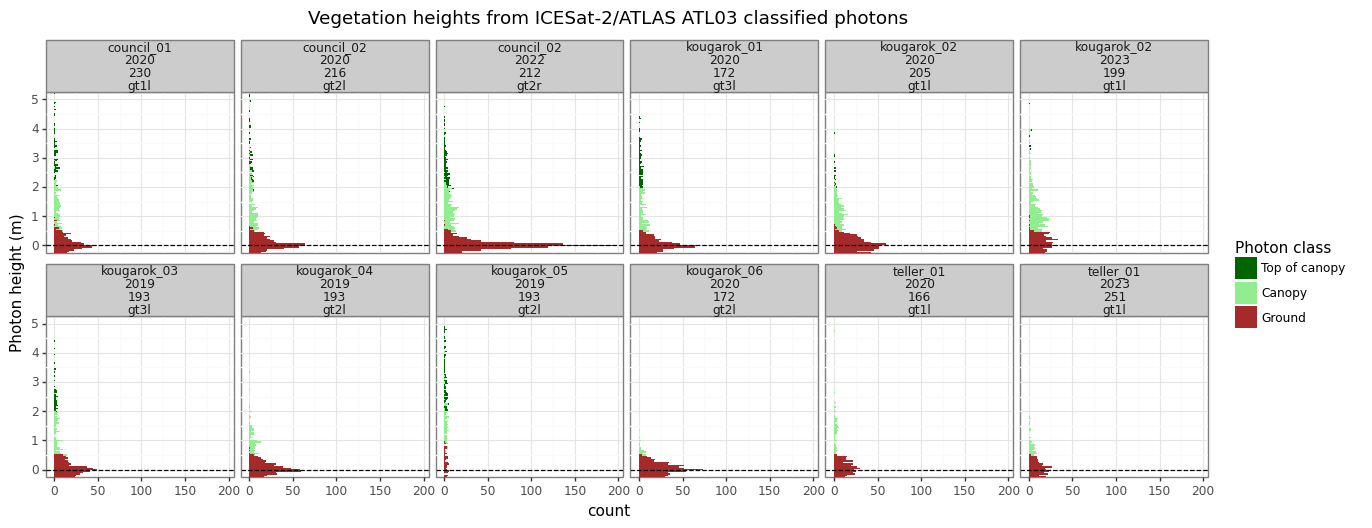

<ggplot: (1418601072192)>

In [21]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(atl03_field_gdf, aes('height', fill='class_name', group='class_name'))
        + labs(x = 'Photon height (m)', title='Vegetation heights from ICESat-2/ATLAS ATL03 classified photons')
        + scale_fill_manual(values = class_color_list, labels=class_name_list, name='Photon class')
        + geom_histogram(binwidth=0.05)
        + geom_vline(xintercept=0, linetype='dashed', size=0.5, color='black')
        + facet_wrap(' ~ site + year + doy + beam', ncol=6)#, scales = 'free_x')
    + coord_flip(xlim = (0,5))
    + theme_bw() 
)

## Read footprints, get paths to various Deep Learning CHM results

`code/above-shrubs/notebooks/footprint_predictions.ipynb`

In [23]:
from basemaplib import *

In [24]:
# NASA CNN CHM footprints
footprints_chm_v1_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_development_chm_v1.gpkg')#footprints_chm_20231014_chm_002m.gpkg

# Footprints used for variety of DINOv2 flavor extractions
# v2.1 ViT DINOv2_rs
footprints_chm_v2_dinov2_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_v2_dinov2_chm_v1.gpkg')

# v2.2.1 ViT DINOv2_rs: 'scalemae' if what we called our second dinov2 run (v2.21)... first one (v2.1) was garbage and we never fixed it.
footprints_chm_v2_scalemae = footprints_chm_v2_dinov2_gdf.copy()
footprints_chm_v2_scalemae['path'] = footprints_chm_v2_scalemae.path.str.replace('dinov2-chm-v1','scalemae')

# v2.2.2 ViT DINOv2_rs: still uses the scalemae loss function - bu re-weighted to penalize underestimates of taller shrubs
footprints_chm_v2_dinov2_v2_22 = footprints_chm_v2_dinov2_gdf.copy()
#footprints_chm_v2_dinov2_v2_22['path'] = footprints_chm_v2_dinov2_v2_22.path.str.replace('dinov2-chm-v1','2.2/dinov2_rs') 
footprints_chm_v2_dinov2_v2_22['path'] = footprints_chm_v2_dinov2_v2_22.path.str.replace('dinov2-chm-v1','dinov2_rs/2.2.2')

# v2.2.3 ViT DINOv2_rs: still uses the scalemae loss function - bu re-weighted to penalize underestimates of taller shrubs - upper boundary case (no good)
footprints_chm_v2_dinov2_v2_23 = footprints_chm_v2_dinov2_gdf.copy()
footprints_chm_v2_dinov2_v2_23['path'] = footprints_chm_v2_dinov2_v2_23.path.str.replace('dinov2-chm-v1','dinov2_rs/2.2.3') 

# v2.2.4 ViT DINOv2_rs: still uses the scalemae loss function - bu re-weighted to penalize underestimates of taller shrubs - update....
footprints_chm_v2_dinov2_v2_24 = footprints_chm_v2_dinov2_gdf.copy()
footprints_chm_v2_dinov2_v2_24['path'] = footprints_chm_v2_dinov2_v2_24.path.str.replace('dinov2-chm-v1','dinov2_rs/2.2.4') 

# Custom Unet redo v1.5.1, etc
footprints_chm_v151_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_custom_unet_1.5.1.gpkg')
footprints_chm_v152_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_custom_unet_1.5.2.gpkg')

# Dinov3
#footprints_chm_dinov3_v2321_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_dinov3_2.3.2.1.gpkg')
footprints_chm_dinov3_v3321_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_dinov3_3.3.2.1.gpkg')
footprints_chm_dinov3_v3322_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_dinov3_3.3.2.2.gpkg')
footprints_chm_dinov3_v3323_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_dinov3_3.3.2.3.gpkg')
footprints_chm_dinov3_v3324_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_dinov3_3.3.2.4.gpkg')
footprints_chm_dinov3_v4322_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_dinov3_4.3.2.2.gpkg')
footprints_chm_dinov3_v4323_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_dinov3_4.3.2.3.gpkg')

#### Get chm footprints at field sites

In [25]:
def gdf_selection(gdf1, gdf2):
    return gdf1[gdf1.geometry.apply(lambda x: any(x.intersects(y) for y in gdf2.geometry))]

footprints_chm_v1_at_uav = gdf_selection(footprints_chm_v1_gdf, footprint_uav_gdf.to_crs(footprints_chm_v1_gdf.crs))
footprints_chm_v2_dinov2_at_uav = gdf_selection(footprints_chm_v2_dinov2_gdf, footprint_uav_gdf.to_crs(footprints_chm_v2_dinov2_gdf.crs))
footprints_chm_v2_scalemae_at_uav = gdf_selection(footprints_chm_v2_scalemae, footprint_uav_gdf.to_crs(footprints_chm_v2_scalemae.crs))
footprints_chm_v2_dinov2_v2_22_at_uav = gdf_selection(footprints_chm_v2_dinov2_v2_22, footprint_uav_gdf.to_crs(footprints_chm_v2_dinov2_v2_22.crs))
footprints_chm_v2_dinov2_v2_23_at_uav = gdf_selection(footprints_chm_v2_dinov2_v2_23, footprint_uav_gdf.to_crs(footprints_chm_v2_dinov2_v2_23.crs))
footprints_chm_v2_dinov2_v2_24_at_uav = gdf_selection(footprints_chm_v2_dinov2_v2_24, footprint_uav_gdf.to_crs(footprints_chm_v2_dinov2_v2_24.crs))

footprints_chm_v151_at_uav = gdf_selection(footprints_chm_v151_gdf, footprint_uav_gdf.to_crs(footprints_chm_v151_gdf.crs))
footprints_chm_v152_at_uav = gdf_selection(footprints_chm_v152_gdf, footprint_uav_gdf.to_crs(footprints_chm_v152_gdf.crs))

footprints_chm_dinov3_v3321_at_uav = gdf_selection(footprints_chm_dinov3_v3321_gdf, footprint_uav_gdf.to_crs(footprints_chm_dinov3_v3321_gdf.crs))
footprints_chm_dinov3_v3322_at_uav = gdf_selection(footprints_chm_dinov3_v3322_gdf, footprint_uav_gdf.to_crs(footprints_chm_dinov3_v3322_gdf.crs))
footprints_chm_dinov3_v3323_at_uav = gdf_selection(footprints_chm_dinov3_v3323_gdf, footprint_uav_gdf.to_crs(footprints_chm_dinov3_v3323_gdf.crs))
footprints_chm_dinov3_v3324_at_uav = gdf_selection(footprints_chm_dinov3_v3324_gdf, footprint_uav_gdf.to_crs(footprints_chm_dinov3_v3324_gdf.crs))

footprints_chm_dinov3_v4322_at_uav = gdf_selection(footprints_chm_dinov3_v4322_gdf, footprint_uav_gdf.to_crs(footprints_chm_dinov3_v4322_gdf.crs))

footprints_chm_dinov3_v4323_at_uav = gdf_selection(footprints_chm_dinov3_v4323_gdf, footprint_uav_gdf.to_crs(footprints_chm_dinov3_v4323_gdf.crs))


### Get common set of `catids` for all sets of `CHM`

In [26]:
CHM_CATID_LIST = footprints_chm_v2_scalemae_at_uav.catid.to_list()

In [27]:
footprints_chm_v1_at_uav = footprints_chm_v1_at_uav[footprints_chm_v1_at_uav.catid.isin(CHM_CATID_LIST)]
footprints_chm_v1_at_uav.shape

(10, 14)

In [28]:
footprints_chm_v2_dinov2_at_uav.shape

(10, 14)

In [29]:
footprints_chm_at_uav = pd.concat([footprints_chm_v1_at_uav, footprints_chm_v2_dinov2_at_uav, 
                                   footprints_chm_v2_scalemae_at_uav, footprints_chm_v2_dinov2_v2_22, footprints_chm_v2_dinov2_v2_23,footprints_chm_v2_dinov2_v2_24,
                                  footprints_chm_v151_at_uav, footprints_chm_v152_at_uav,
                                footprints_chm_dinov3_v3321_at_uav, footprints_chm_dinov3_v3322_at_uav, footprints_chm_dinov3_v3323_at_uav, footprints_chm_dinov3_v3324_at_uav,
                                footprints_chm_dinov3_v4322_at_uav, footprints_chm_dinov3_v4323_at_uav])

In [30]:
footprints_chm_at_uav['filepath'] = footprints_chm_at_uav[['path', 'file']].apply(lambda row: os.path.join(*row), axis=1)
#footprints_chm_at_uav['path_new'] = footprints_chm_at_uav.path.str.split('chm/20231014_chm/002m', expand=True)[0] + 'development/chm/v1'

In [31]:
footprints_chm_at_uav.path.to_list()

['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v2/dinov2-chm-v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v2/dinov2-chm-v1',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v2/dinov2-chm-v

In [32]:
# Fall 2024 strips expected for CHM 
footprints_toa_evhr_at_uav = gdf_selection(gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_evhr_.gpkg'), footprint_uav_gdf.to_crs(footprints_chm_at_uav.crs))
footprints_toa_evhr_at_uav['filepath'] = footprints_toa_evhr_at_uav[['path', 'file']].apply(lambda row: os.path.join(*row), axis=1)
footprints_toa_evhr_at_uav.filepath.to_list()

['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/evhr_QB/5-toas/QB02_20080727_P1BS_1010010008581D00-toa.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/evhr_QB/5-toas/QB02_20080727_M1BS_1010010008581D00-toa.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/evhr_QB/5-toas/QB02_20060901_P1BS_10100100052D3D00-toa.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/evhr_QB/5-toas/QB02_20060901_M1BS_10100100052D3D00-toa.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/evhr_QB/5-toas/QB02_20060827_P1BS_10100100052AB200-toa.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/evhr_QB/5-toas/QB02_20060827_M1BS_10100100052AB200-toa.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/evhr_QB/5-toas/QB02_20040711_P1BS_101001000319CD00-toa.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/evhr_QB/5-toas/QB02_20040711_M1BS_101001000319CD00-toa.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/evhr_WV03/5-toas/WV03_20220819_M1BS

In [33]:
# m = field_ref_gdf.drop('point_datetime', axis=1).explore(name='Field points', column='height_cm_200cm', cmap='inferno',
#     m=atl03_field_gdf.drop('datetime', axis=1).explore(name='ATL03 photons',
#         m=atl08_30m_gdf.explore(name='ATL08 30m points',
#             m=atl08_field_gdf.drop('datetime', axis=1).explore(name='ATL08 100m points',
#                 m=footprint_uav_gdf.drop('date', axis=1).explore(name='UAV extents',
#                     m=footprints_chm_at_uav.drop('date', axis=1).explore(name='VHR CHM extents',
#                         m=footprints_toa_evhr_at_uav.drop('date', axis=1).explore(name='VHR TOA upcoming', 
#                         color='red', height=500, width=500),
#                     color='darkgreen'),
#                 color='gray'), 
#             color='k', style_kwds = {'radius':10}), 
#         color='red', style_kwds = {'radius':3}), 
#     color='green', style_kwds = {'radius':1}),
# color='purple', style_kwds = {'radius':1})

# # Add custom basemaps
# basemaps['Boreal Height'].add_to(m)
# basemaps['Google Terrain'].add_to(m)
# basemaps['Imagery'].add_to(m)
# basemaps['ESRINatGeo'].add_to(m)
# basemaps['basemap_gray'].add_to(m)
# folium.LayerControl().add_to(m)
# plugins.Fullscreen(position='bottomleft').add_to(m)
# m

## Extract UAV DSM & DTM pixels to `ATL03`, `ATL08 100m`, and `ATL08 30m`

In [158]:
DSM_DIR = f'{OUTDIR}/DSM_COG'
DTM_DIR = f'{OUTDIR}/DTM_COG'
CHM_030cm_DIR = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/uas/CHM_MAX_030cm_COG'
CHM_200cm_DIR = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/uas/CHM_MAX_200cm_COG'

# Sorting enables reliable site enumeration 
fn_uavdsm_list = sorted(glob.glob(f'{DSM_DIR}/*.tif'))
fn_uavdtm_list = sorted(glob.glob(f'{DTM_DIR}/*.tif'))
fn_uavchm030cm_list = sorted(glob.glob(f'{CHM_030cm_DIR}/*.tif'))
fn_uavchm200cm_list = sorted(glob.glob(f'{CHM_200cm_DIR}/*.tif'))

In [159]:
from shapely.geometry import box, Point
import contextily as ctx

In [160]:
def extract_raster_points_for_site(gdf_site, ds_list, bandnum_list, ds_names_list, DEBUG=False):
    r_gdf_list = []
    c_gdf_list = []
    for i,ds in enumerate(ds_list):
        bandnum = bandnum_list[i]
        ds_name = ds_names_list[i]
        #print(ds_name)
        
        # Reproject gdf to crs of ds before sampling
        if DEBUG: print(ds.crs)
        if DEBUG: 
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            print(ds.bounds)
            r_gdf = gpd.GeoDataFrame({"id":ds_name,"geometry":[box(*ds.bounds)]}, crs=ds.crs)
            r_gdf.to_crs(4326).plot(ax=ax, color='gray')
            r_gdf_list.append(r_gdf.to_crs(4326))
            
        gdf_site_reprj = gdf_site.to_crs(ds.crs).copy()
        # Get coords for sampling sampling
        coord_list = [(x,y) for x,y in zip(gdf_site_reprj['geometry'].x , gdf_site_reprj['geometry'].y)]
        if DEBUG: print(f'{len(coord_list)} coordinates.')
        # Sample raster and put back into original gdf
        list_samples = pd.Series([x[bandnum-1] for x in ds.sample(coord_list)])
        if DEBUG: print(list_samples[0:5])
        if 'nasa' in ds_name: list_samples = list_samples / 10 # stored as int16 in decimeters
        gdf_site[ds_name] = np.array(list_samples)
        if DEBUG: 
            #print(gdf_site[ds_name])
            c_gdf = gpd.GeoDataFrame({"id":1,"geometry":[Point(i[0], i[1]) for i in coord_list]}, crs=ds.crs)
            ax = c_gdf.to_crs(4326).plot(ax=ax, color='red', markersize=0.5)
            ax.set_title(ds_name)
            #ctx.add_basemap(ax=ax, zoom=2)
            plt.show()
            c_gdf_list.append(c_gdf.to_crs(4326))
            
            
        print(f'\tMedian of {ds_name} (n={gdf_site.shape[0]}): {gdf_site[ds_name].median()}')
        if DEBUG: print(gdf_site[ds_name][0:2])
        
    if 'dsm_uav' in gdf_site.columns:    
        gdf_site['ht_uav'] = gdf_site['dsm_uav'] - gdf_site['dtm_uav']
    # if 'ht_uav' in gdf_site.columns:
    #     gdf_site['ht_uavchm030'] = gdf_site['ht_uavchm030'] / 100 # from cm to m
    #     gdf_site['ht_uavchm200'] = gdf_site['ht_uavchm200'] / 100 # from cm to m
    if 'dsm_ifsar' in gdf_site.columns: 
        gdf_site['ht_ifsar'] = gdf_site['dsm_ifsar'] - gdf_site['dtm_ifsar']
    # tmp fix to scale dinov2 output
    for colname in gdf_site.columns:
        if colname.endswith('chm'): 
            print(colname)
            gdf_site[colname] = gdf_site[colname] / 10
    
    if DEBUG:
        return gdf_site, r_gdf_list, c_gdf_list
    else:
        return gdf_site

In [161]:
sorted(atl03_field_gdf.site.unique())

['council_01',
 'council_02',
 'kougarok_01',
 'kougarok_02',
 'kougarok_03',
 'kougarok_04',
 'kougarok_05',
 'kougarok_06',
 'teller_01']

## Extract height values from various rasters  
 - NASA ABR CHM 10m version of CNN CHM v1
 - IFSAR (dsm/dtm)  
 - boreal height (ABoVE Duncansano)  
 - NASA ABR CHM - various versions
 - Tolan (META)  
 - Lang  
 - Potapov

In [162]:
nasa_chm_ds = rasterio.open(nasa_chm_vrt)

In [163]:
# Height user for VHR model training
ifsar_dtm_ds = rasterio.open('/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dtm_20221222.tif')
ifsar_dsm_ds = rasterio.open('/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dsm_20221222.tif')

In [164]:
# Duncansano Height
boreal_ht_H30_2020_ds = rasterio.open('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/height_rasters/boreal_ht_2020_H30.vrt')
boreal_ht_S1H30_2020_ds = rasterio.open('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/height_rasters/boreal_ht_2020_S1H30.vrt')

In [165]:
footprints_chm_at_uav.path.to_list()[0]

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1'

In [166]:
# NASA | ABR Macansano-Vega Height that intersect field sites
ds_vhr_list = []
names_vhr_list = []

chm_fn_list = footprints_chm_at_uav.filepath.to_list()

for chm_fn in chm_fn_list:
    ds_vhr_list.append(rasterio.open(chm_fn))
    print(os.path.basename(chm_fn))
    names_vhr_list.append('ht_' + "_".join([os.path.basename(chm_fn).split('_')[i] for i in [1,3]] ).replace('-sr-02m.','').replace('.tif','') +'_'+os.path.basename(os.path.dirname(chm_fn)).split('_')[0]) #.split('-')[0])
    
bands_vhr_list = [1 for ds in ds_vhr_list] 
chm_fn_list
names_vhr_list

WV02_20110727_M1BS_103001000D914900-sr-02m.cnn-chm-v1.tif
WV02_20120721_M1BS_103001001AB23900-sr-02m.cnn-chm-v1.tif
WV02_20160817_M1BS_103001005B484100-sr-02m.cnn-chm-v1.tif
WV02_20190820_M1BS_10300100954DE000-sr-02m.cnn-chm-v1.tif
WV02_20190820_M1BS_10300100968FB300-sr-02m.cnn-chm-v1.tif
WV02_20190820_M1BS_1030010099BF2F00-sr-02m.cnn-chm-v1.tif
WV02_20200722_M1BS_10300100AB1FD100-sr-02m.cnn-chm-v1.tif
WV03_20170719_M1BS_104001002F7A2E00-sr-02m.cnn-chm-v1.tif
WV03_20190822_M1BS_104001005054F700-sr-02m.cnn-chm-v1.tif
WV03_20200704_M1BS_104001005EADB900-sr-02m.cnn-chm-v1.tif
WV02_20110727_M1BS_103001000D914900-sr-02m.chm.tif
WV02_20160817_M1BS_103001005B484100-sr-02m.chm.tif
WV02_20190820_M1BS_10300100954DE000-sr-02m.chm.tif
WV02_20190820_M1BS_10300100968FB300-sr-02m.chm.tif
WV02_20190820_M1BS_1030010099BF2F00-sr-02m.chm.tif
WV02_20200722_M1BS_10300100AB1FD100-sr-02m.chm.tif
WV03_20170719_M1BS_104001002F7A2E00-sr-02m.chm.tif
WV03_20190822_M1BS_104001005054F700-sr-02m.chm.tif
WV03_2020070

['ht_20110727_103001000D914900cnn-chm-v1_v1',
 'ht_20120721_103001001AB23900cnn-chm-v1_v1',
 'ht_20160817_103001005B484100cnn-chm-v1_v1',
 'ht_20190820_10300100954DE000cnn-chm-v1_v1',
 'ht_20190820_10300100968FB300cnn-chm-v1_v1',
 'ht_20190820_1030010099BF2F00cnn-chm-v1_v1',
 'ht_20200722_10300100AB1FD100cnn-chm-v1_v1',
 'ht_20170719_104001002F7A2E00cnn-chm-v1_v1',
 'ht_20190822_104001005054F700cnn-chm-v1_v1',
 'ht_20200704_104001005EADB900cnn-chm-v1_v1',
 'ht_20110727_103001000D914900chm_dinov2-chm-v1',
 'ht_20160817_103001005B484100chm_dinov2-chm-v1',
 'ht_20190820_10300100954DE000chm_dinov2-chm-v1',
 'ht_20190820_10300100968FB300chm_dinov2-chm-v1',
 'ht_20190820_1030010099BF2F00chm_dinov2-chm-v1',
 'ht_20200722_10300100AB1FD100chm_dinov2-chm-v1',
 'ht_20170719_104001002F7A2E00chm_dinov2-chm-v1',
 'ht_20190822_104001005054F700chm_dinov2-chm-v1',
 'ht_20200704_104001005EADB900chm_dinov2-chm-v1',
 'ht_20120721_103001001AB23900chm_dinov2-chm-v1',
 'ht_20110727_103001000D914900chm_scalem

In [167]:
# Misc other published Height maps
tolan_2023_ht_ds = rasterio.open('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/height_rasters/tolan_2023_canopy_height_m_sew_pen_2024_sa.tif')
lang_2022_ht_ds = rasterio.open('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/height_rasters/lang_2022_canopy_height_m_sew_pen_2024_sa.tif')
potapov_2021_ht_ds = rasterio.open('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/height_rasters/potapov_2021_canopy_height_m_sew_pen_2024_sa.tif')

In [168]:
ds_misc_list = [ifsar_dsm_ds, ifsar_dtm_ds, boreal_ht_H30_2020_ds, boreal_ht_S1H30_2020_ds, tolan_2023_ht_ds, lang_2022_ht_ds, potapov_2021_ht_ds, nasa_chm_ds]
len(ds_misc_list)

8

In [169]:
print(boreal_ht_S1H30_2020_ds.profile)

{'driver': 'VRT', 'dtype': 'float32', 'nodata': nan, 'width': 9000, 'height': 9000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 548521.9999999953,
       0.0, -30.0, 3033304.0000000093), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}


In [170]:
sorted(footprint_uav_gdf.site.unique())

['council_01',
 'council_02',
 'kougarok_01',
 'kougarok_02',
 'kougarok_03',
 'kougarok_04',
 'kougarok_05',
 'kougarok_06',
 'teller_01']

#### Create a single reference heights dataframe

In [171]:
atl08_30m_gdf.beam_type.unique()
atl03_field_gdf.beam.unique()
field_ref_gdf.columns

Index(['parent_id', 'site', 'line_id', 'point_id', 'child_id',
       'point_distance_m', 'species_top_hit', 'height_cm_30cm', 'species_30cm',
       'height_cm_200cm', 'species_200cm', 'species_top_hit_agg',
       'species_30cm_agg', 'species_200cm_agg', 'species_top_hit_orig',
       'species_30cm_orig', 'species_200cm_orig', 'point_datetime',
       'point_location', 'geometry'],
      dtype='object')

In [172]:
def classname_canopy_obs(gdf, class_color_list=['lightgrey','brown','lightgreen','darkgreen'], class_name_list=['Noise','Ground','Canopy','Top of canopy']):
    '''Function to assign name/color to canopy observation class''',
    
    # Add class names and colors
    class_list = [-1, 0, 1, 2, 3]
    
    if 'class' in gdf.columns:
        gdf['class_name']  = pd.cut(gdf['class'], class_list , labels = class_name_list)
        gdf['color']  = pd.cut(gdf['class'], class_list , labels = class_color_list)
    
    return gdf

In [173]:
# Create a combined gdf
tmp1 = atl03_field_gdf[['site','geometry','height','class','elev','beam','doy','x','y']] # need beam and doy for transect plots in plotlib
tmp1['type_ref'] = 'ATL03'
tmp1['height_ref'] = tmp1.height

tmp2 = atl08_field_gdf[['site','geometry','h_canopy']]
tmp2['type_ref'] = 'ATL08'
tmp2['class'] = 3 #'Top of canopy'
tmp2['height_ref'] = tmp2.h_canopy
tmp2['beam'] = tmp2['doy'] = tmp2['x'] = tmp2['y'] = 'n/a'
tmp2['elev'] = atl08_field_gdf['h_te_median']

tmp3 = atl08_30m_gdf[['site','geometry','h_canopy']]
tmp3['type_ref'] = 'ATL08 30m'
tmp3['class'] = 3 #'Top of canopy'
tmp3['height_ref'] = tmp3.h_canopy
tmp3['beam'] = tmp3['doy'] = tmp3['x'] = tmp3['y'] = 'n/a'
tmp3['elev'] = atl08_30m_gdf['h_te_median']

tmp4 = field_ref_gdf[['site','geometry','height_cm_200cm']]
tmp4['type_ref'] = 'field 2m'
tmp4['class'] = 3 #'Top of canopy'
tmp4['height_ref'] = tmp4.height_cm_200cm / 100
tmp4['elev'] = tmp4['beam'] = tmp4['doy'] = tmp4['x'] = tmp4['y'] = 'n/a'

tmp5 = field_ref_gdf[['site','geometry','height_cm_30cm']]
tmp5['type_ref'] = 'field 0.3m'
tmp5['class'] = 2 #'canopy'
tmp5['height_ref'] = tmp5.height_cm_30cm / 100
tmp5['elev'] = tmp5['beam'] = tmp5['doy'] = tmp5['x'] = tmp5['y'] = 'n/a'

ref_ht_points = classname_canopy_obs(pd.concat([df[['type_ref','class','site','beam','doy','x','y','elev','height_ref','geometry']].to_crs(4326) for df in [tmp1,tmp2,tmp3,tmp4,tmp5]]))

In [174]:
ref_ht_points.type_ref.unique()

array(['ATL03', 'ATL08', 'ATL08 30m', 'field 2m', 'field 0.3m'],
      dtype=object)

### Extract ATL03 to field points: buffer and summarize - TODO

#### buffer the field points by 2m

In [175]:
BUF_SZ_M = 2

In [176]:
field_ref_gdf_buf2m = field_ref_gdf.copy()
field_ref_gdf_buf2m['geometry'] = field_ref_gdf.to_crs(3857).buffer(BUF_SZ_M).to_crs(4326)
field_ref_gdf_buf2m.shape

(1140, 20)

<Axes: >

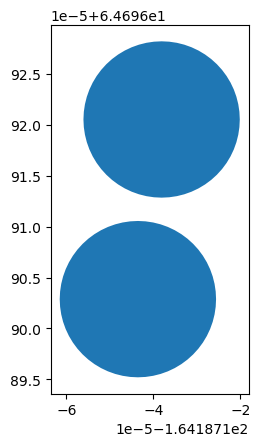

In [177]:
field_ref_gdf_buf2m.head(2).plot()

In [178]:
field_atl03_merged = gpd.sjoin(field_ref_gdf_buf2m[['height_cm_200cm','geometry']], atl03_field_gdf[['class_name','height','geometry']],   how="left", predicate='within')

In [179]:
#field_atl03_merged['geometry'].head().explore()
field_atl03_merged.tail()

height_cm_200cm                                           geometry  \
1135            102.0  POLYGON ((-165.95366 64.75947, -165.95366 64.7...   
1136             54.0  POLYGON ((-165.95367 64.75949, -165.95367 64.7...   
1137             64.0  POLYGON ((-165.95367 64.75950, -165.95367 64.7...   
1138             65.0  POLYGON ((-165.95368 64.75952, -165.95368 64.7...   
1139             45.0  POLYGON ((-165.95368 64.75954, -165.95368 64.7...   

      index_right class_name  height  
1135          NaN        NaN     NaN  
1136          NaN        NaN     NaN  
1137          NaN        NaN     NaN  
1138          NaN        NaN     NaN  
1139          NaN        NaN     NaN

In [180]:
#field_atl03_merged.groupby('class_name').agg('mean')

In [181]:
len([ifsar_dsm_ds, ifsar_dtm_ds, boreal_ht_H30_2020_ds, boreal_ht_S1H30_2020_ds, tolan_2023_ht_ds, lang_2022_ht_ds, potapov_2021_ht_ds, nasa_chm_ds])
len(['dsm_ifsar','dtm_ifsar', 'ht_H30_2020, ht_S1H30_2020','ht_tolan','ht_lang','ht_potapov','ht_nasa_cnn_10m'])

7

### Extract the raster values for all reference points

In [182]:
%%time

warnings.filterwarnings('ignore')

extracted_All_ref_gdf_list = []
bandnum = 1

# Loop over sites
for i, site in enumerate(sorted(footprint_uav_gdf.site.unique())):
    
    print(site)
    # These are sorted - so ordered by site, so are indexed with the sorted sites of the loop
    uavdsm_fn = [fn for fn in fn_uavdsm_list if site in fn][0]
    print(uavdsm_fn)
    uav_dsm_ds = rasterio.open(uavdsm_fn)
    uav_dtm_ds = rasterio.open([fn for fn in fn_uavdtm_list if site in fn][0])
    
    # UAV CHMs computed using MAX rule every 2m
    uav_chm030_ds = rasterio.open([fn for fn in fn_uavchm030cm_list if site in fn][0])
    uav_chm200_ds = rasterio.open([fn for fn in fn_uavchm200cm_list if site in fn][0])

    ds_list_input = [uav_dsm_ds, uav_dtm_ds, uav_chm030_ds, uav_chm200_ds] + ds_misc_list + ds_vhr_list
    bandnum_list_input = [bandnum for ds in ds_list_input]
    names_list_input = ['dsm_uav','dtm_uav', 'ht_uavchm030', 'ht_uavchm200'] + ['dsm_ifsar','dtm_ifsar', 'ht_boreal_H30_2020', 'ht_boreal_S1H30_2020','ht_tolan','ht_lang','ht_potapov','ht_nasa_cnn_10m'] + names_vhr_list
    
    print('  All ref points')
    extracted_All_ref_gdf_list.append(     extract_raster_points_for_site(ref_ht_points[ref_ht_points.site == site],     ds_list_input, bandnum_list_input, names_list_input, DEBUG=False))

council_01
/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/DSM_COG/council_01_20240812_100m_dsm.tif
  All ref points
	Median of dsm_uav (n=935): 78.12749481201172
	Median of dtm_uav (n=935): 77.87251281738281
	Median of ht_uavchm030 (n=935): 0.04477691650390625
	Median of ht_uavchm200 (n=935): 0.23281478881835938
	Median of dsm_ifsar (n=935): 97.77288055419922
	Median of dtm_ifsar (n=935): 97.19258880615234
	Median of ht_boreal_H30_2020 (n=935): 3.9911201000213623
	Median of ht_boreal_S1H30_2020 (n=935): 3.169420003890991
	Median of ht_tolan (n=935): 0.0
	Median of ht_lang (n=935): 9.0
	Median of ht_potapov (n=935): 0.0
	Median of ht_nasa_cnn_10m (n=935): 0.2
	Median of ht_20110727_103001000D914900cnn-chm-v1_v1 (n=935): -9999.0
	Median of ht_20120721_103001001AB23900cnn-chm-v1_v1 (n=935): 0.024255352094769478
	Median of ht_20160817_103001005B484100cnn-chm-v1_v1 (n=935): 0.3096177279949188
	Median of ht_20190820_10300100954DE000cnn-chm-v1_v

In [183]:
all_ref_gdf_extract = pd.concat(extracted_All_ref_gdf_list)
all_ref_gdf_extract.shape

(10660, 165)

In [184]:
all_ref_gdf_extract.columns

Index(['type_ref', 'class', 'site', 'beam', 'doy', 'x', 'y', 'elev',
       'height_ref', 'geometry',
       ...
       'ht_20160817_103001005B484100chm_4.3.2.3',
       'ht_20190820_10300100954DE000chm_4.3.2.3',
       'ht_20190820_10300100968FB300chm_4.3.2.3',
       'ht_20190820_1030010099BF2F00chm_4.3.2.3',
       'ht_20200722_10300100AB1FD100chm_4.3.2.3',
       'ht_20170719_104001002F7A2E00chm_4.3.2.3',
       'ht_20190822_104001005054F700chm_4.3.2.3',
       'ht_20200704_104001005EADB900chm_4.3.2.3', 'ht_uav', 'ht_ifsar'],
      dtype='object', length=165)

In [185]:
pattern = '|'.join(['ht_'])
all_ref_gdf_extract.filter(regex=pattern).columns.to_list() 

['height_ref',
 'ht_uavchm030',
 'ht_uavchm200',
 'ht_boreal_H30_2020',
 'ht_boreal_S1H30_2020',
 'ht_tolan',
 'ht_lang',
 'ht_potapov',
 'ht_nasa_cnn_10m',
 'ht_20110727_103001000D914900cnn-chm-v1_v1',
 'ht_20120721_103001001AB23900cnn-chm-v1_v1',
 'ht_20160817_103001005B484100cnn-chm-v1_v1',
 'ht_20190820_10300100954DE000cnn-chm-v1_v1',
 'ht_20190820_10300100968FB300cnn-chm-v1_v1',
 'ht_20190820_1030010099BF2F00cnn-chm-v1_v1',
 'ht_20200722_10300100AB1FD100cnn-chm-v1_v1',
 'ht_20170719_104001002F7A2E00cnn-chm-v1_v1',
 'ht_20190822_104001005054F700cnn-chm-v1_v1',
 'ht_20200704_104001005EADB900cnn-chm-v1_v1',
 'ht_20110727_103001000D914900chm_dinov2-chm-v1',
 'ht_20160817_103001005B484100chm_dinov2-chm-v1',
 'ht_20190820_10300100954DE000chm_dinov2-chm-v1',
 'ht_20190820_10300100968FB300chm_dinov2-chm-v1',
 'ht_20190820_1030010099BF2F00chm_dinov2-chm-v1',
 'ht_20200722_10300100AB1FD100chm_dinov2-chm-v1',
 'ht_20170719_104001002F7A2E00chm_dinov2-chm-v1',
 'ht_20190822_104001005054F700chm

In [186]:
#all_ref_gdf_extract.columns

In [187]:
all_ref_m = pd.melt(all_ref_gdf_extract, id_vars=['height_ref','site','type_ref','class_name','color','beam','doy','x','y'], 
                    value_vars = all_ref_gdf_extract.filter(regex = pattern).columns.to_list(), 
                    var_name = 'source',
                    #value_name = 'ht_value'
                   )
all_ref_m.shape

(1588340, 11)

In [188]:
YEAR_REF_HEIGHT = 2024

In [189]:
all_ref_gdf_extract.columns

Index(['type_ref', 'class', 'site', 'beam', 'doy', 'x', 'y', 'elev',
       'height_ref', 'geometry',
       ...
       'ht_20160817_103001005B484100chm_4.3.2.3',
       'ht_20190820_10300100954DE000chm_4.3.2.3',
       'ht_20190820_10300100968FB300chm_4.3.2.3',
       'ht_20190820_1030010099BF2F00chm_4.3.2.3',
       'ht_20200722_10300100AB1FD100chm_4.3.2.3',
       'ht_20170719_104001002F7A2E00chm_4.3.2.3',
       'ht_20190822_104001005054F700chm_4.3.2.3',
       'ht_20200704_104001005EADB900chm_4.3.2.3', 'ht_uav', 'ht_ifsar'],
      dtype='object', length=165)

In [190]:
# =============================================================================
# MODEL CONFIGURATION - Define all model versions and their attributes here
# =============================================================================

model_configs = {
        'vhr_nasa_dinov3_4323_2m': {
        'regex': '_4.3.2.3$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v4.3.2.3 (DINOv3)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
        'vhr_nasa_dinov3_4322_2m': {
        'regex': '_4.3.2.2$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v4.3.2.2 (DINOv3)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
        'vhr_nasa_dinov3_3321_2m': {
        'regex': '_3.3.2.1$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v3.3.2.1 (DINOv3)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
        'vhr_nasa_dinov3_3322_2m': {
        'regex': '_3.3.2.2$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v3.3.2.2 (DINOv3)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
        'vhr_nasa_dinov3_3323_2m': {
        'regex': '_3.3.2.3$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v3.3.2.3 (DINOv3)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
        'vhr_nasa_dinov3_3324_2m': {
        'regex': '_3.3.2.4$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v3.3.2.4 (DINOv3)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
    'vhr_nasa_cnn_2m': {
        'regex': 'cnn-chm-v1',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v1.0 (UNet)',
        'source_extent': 'Regional',
        'source_res': ' 2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
    'vhr_nasa_dinov2_2m': {
        'regex': '_dinov2-chm-v1$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v2.1 (ViT DINOv2)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
    'vhr_nasa_dinov2rsscalmae1_2m': {
        'regex': '_scalemae$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v2.2.1 (ViT DINOv2-RS)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
    'vhr_nasa_dinov2rsscalmae2_2m': {
        'regex': '_2.2.2$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v2.2.2 (ViT DINOv2-RS)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
    'vhr_nasa_dinov2rsscalmae3_2m': {
        'regex': '_2.2.3$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v2.2.3 (ViT DINOv2-RS)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
    'vhr_nasa_dinov2rsscalmae4_2m': {
        'regex': '_2.2.4$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v2.2.4 (ViT DINOv2-RS)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
    'vhr_nasa_cnnredo151_2m': {
        'regex': '_1.5.1$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v1.5.1 (UNet)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
    'vhr_nasa_cnnredo152_2m': {
        'regex': '_1.5.2$',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v1.5.2 (UNet)',
        'source_extent': 'Regional',
        'source_res': '2m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14 yr dif'
    },
    'airborne': {
        'regex': 'ht_ifsar',
        'source_cat': 'Observation',
        'source_mod_dev_app_class': 'n/a',
        'source_type': 'CHM (training; IFSAR)',
        'source_extent': 'Local',
        'source_res': '5m',
        'source_temp': '2012',
        'source_temp_dif_ref': '12  yr dif'
    },
    'vhr_nasa_cnn_10m': {
        'regex': 'ht_nasa',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'VHR CHM v1.0 (UNet)',
        'source_extent': 'Regional',
        'source_res': '10m',
        'source_temp': '2010-2020',
        'source_temp_dif_ref': '4-14  yr dif'
    },
    'boreal_H30_2020_30m': {
        'regex': 'ht_boreal_H30_2020',
        'source_cat': 'Machine Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'NASA|UMd HLS',
        'source_extent': 'Circumpolar',
        'source_res': '30m',
        'source_temp': '2020',
        'source_temp_dif_ref': '4 yr dif'
    },
    'boreal_S1H30_2020_30m': {
        'regex': 'ht_boreal_S1H30_2020',
        'source_cat': 'Machine Learning',
        'source_mod_dev_app_class': 'boreal|boreal',
        'source_type': 'NASA|UMd S1+HLS',
        'source_extent': 'Circumpolar',
        'source_res': '30m',
        'source_temp': '2020',
        'source_temp_dif_ref': '4 yr dif'
    },
    'global_10m': {
        'regex': 'ht_lang',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': 'temp+trop|boreal',
        'source_type': 'Pub: Lang et al. 2023',
        'source_extent': 'Global',
        'source_res': '10m',
        'source_temp': '2020',
        'source_temp_dif_ref': '4 yr dif'
    },
    'global_30m': {
        'regex': 'ht_potapov',
        'source_cat': 'Machine Learning',
        'source_mod_dev_app_class': 'temp+trop|boreal',
        'source_type': 'Pub: Potapov et al. 2021',
        'source_extent': 'Global',
        'source_res': '30m',
        'source_temp': '2019',
        'source_temp_dif_ref': '5 yr dif'
    },
    'vhr_global': {
        'regex': 'ht_tolan',
        'source_cat': 'Deep Learning',
        'source_mod_dev_app_class': '?',
        'source_type': 'Pub: Tolan et al. 2024',
        'source_extent': 'Global',
        'source_res': ' 2m',
        'source_temp': '2017-2020',
        'source_temp_dif_ref': '4-7 yr dif'
    },
    'uav_orig': {
        'regex': 'ht_uav$',
        'source_cat': 'Observation',
        'source_mod_dev_app_class': 'n/a',
        'source_type': 'UAV',
        'source_extent': 'Local',
        'source_res': '0.02m',
        'source_temp': '2024',
        'source_temp_dif_ref': '0 yr dif'
    },
    'uav_chm': {
        'regex': 'ht_uavchm',
        'source_cat': 'Observation',
        'source_mod_dev_app_class': 'n/a',
        'source_type': 'CHM (ref.; UAV)',
        'source_extent': 'Local',
        'source_res': '0.02m',
        'source_temp': '2024',
        'source_temp_dif_ref': '0 yr dif'
    }
}

In [191]:
# =============================================================================
# COLUMN EXTRACTION - Extract columns for each model
# =============================================================================

model_cols = {}
for model_name, config in model_configs.items():
    model_cols[model_name] = all_ref_gdf_extract.filter(
        regex='|'.join([config['regex']])
    ).columns.to_list()

# Special combined columns
boreal_specific_30m_cols = model_cols['boreal_H30_2020_30m'] + model_cols['boreal_S1H30_2020_30m']

# =============================================================================
# ATTRIBUTE ASSIGNMENT - Create attributes using the configuration
# =============================================================================

def assign_attributes(df, column_name, attribute_key, default_value=''):
    """
    Assign attributes to dataframe based on model configurations.
    
    Parameters:
    - df: DataFrame to modify
    - column_name: Name of the column to create
    - attribute_key: Key in model_configs dict to use for values
    - default_value: Default value if no match found
    """
    result = pd.Series([default_value] * len(df), index=df.index)
    
    for model_name, config in model_configs.items():
        mask = df['source'].isin(model_cols[model_name])
        result[mask] = config[attribute_key]
    
    return result

# Apply all attributes
all_ref_m['source_cat'] = assign_attributes(all_ref_m, 'source_cat', 'source_cat')
all_ref_m['source_mod_dev_app_class'] = assign_attributes(all_ref_m, 'source_mod_dev_app_class', 'source_mod_dev_app_class')
all_ref_m['source_type'] = assign_attributes(all_ref_m, 'source_type', 'source_type')
all_ref_m['source_extent'] = assign_attributes(all_ref_m, 'source_extent', 'source_extent')
all_ref_m['source_res'] = assign_attributes(all_ref_m, 'source_res', 'source_res')
all_ref_m['source_temp'] = assign_attributes(all_ref_m, 'source_temp', 'source_temp')
all_ref_m['source_temp_dif_ref'] = assign_attributes(all_ref_m, 'source_temp_dif_ref', 'source_temp_dif_ref')

In [192]:
# vhr_nasa_cnn_2m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['cnn-chm-v1'])).columns.to_list()
# vhr_nasa_dinov2_2m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['_dinov2-chm-v1$'])).columns.to_list()
# vhr_nasa_dinov2rsscalmae1_2m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['_scalemae$'])).columns.to_list()
# vhr_nasa_dinov2rsscalmae2_2m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['_2.2.2$'])).columns.to_list()
# vhr_nasa_dinov2rsscalmae3_2m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['_2.2.3$'])).columns.to_list()
# vhr_nasa_dinov2rsscalmae4_2m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['_2.2.4$'])).columns.to_list()
# vhr_nasa_cnnredo151_2m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['_1.5.1$'])).columns.to_list()
# vhr_nasa_cnnredo152_2m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['_1.5.2$'])).columns.to_list()
# vhr_nasa_dinov3_3321_2m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['_3.3.2.1$'])).columns.to_list()


# airborne_cols = all_ref_gdf_extract.filter(regex = '|'.join(['ht_ifsar'])).columns.to_list()
# vhr_nasa_cnn_10m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['ht_nasa'])).columns.to_list()

# boreal_H30_2020_30m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['ht_boreal_H30_2020'])).columns.to_list()
# boreal_S1H30_2020_30m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['ht_boreal_S1H30_2020'])).columns.to_list()
# boreal_specific_30m_cols = boreal_H30_2020_30m_cols + boreal_S1H30_2020_30m_cols

# global_10m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['ht_lang'])).columns.to_list()
# global_30m_cols = all_ref_gdf_extract.filter(regex = '|'.join(['ht_potapov'])).columns.to_list()
# vhr_global_cols = all_ref_gdf_extract.filter(regex = '|'.join(['ht_tolan'])).columns.to_list()
# uav_orig_cols = all_ref_gdf_extract.filter(regex = '|'.join(['ht_uav$'])).columns.to_list()
# uav_chm_cols = all_ref_gdf_extract.filter(regex = '|'.join(['ht_uavchm'])).columns.to_list()

# # Source Category
# # very basic classification of the source of the estimate: observation, machine learning, deep learning
# all_ref_m['source_cat'] =  np.where(all_ref_m['source'].isin(vhr_nasa_cnn_2m_cols), 'Deep Learning',
#                                      np.where(all_ref_m['source'].isin(airborne_cols), 'Observation', 
#                                              np.where(all_ref_m['source'].isin(vhr_nasa_cnn_10m_cols), 'Deep Learning', 
#                                                      np.where(all_ref_m['source'].isin(boreal_H30_2020_30m_cols), 'Machine Learning', 
#                                                               np.where(all_ref_m['source'].isin(boreal_S1H30_2020_30m_cols), 'Machine Learning',
#                                                              np.where(all_ref_m['source'].isin(global_10m_cols), 'Deep Learning', 
#                                                                      np.where(all_ref_m['source'].isin(vhr_global_cols), 'Deep Learning', 
#                                                                              np.where(all_ref_m['source'].isin(global_30m_cols), 'Machine Learning', 
#                                                                                      np.where(all_ref_m['source'].isin(uav_orig_cols), 'Observation', 
#                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2_2m_cols), 'Deep Learning', 
#                                                                                                      np.where(all_ref_m['source'].isin(uav_chm_cols), 'Observation', 
#                                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae1_2m_cols), 'Deep Learning', 
#                                                                                                                       np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae2_2m_cols), 'Deep Learning', 
#                                                                                                                                np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae3_2m_cols), 'Deep Learning', 
#                                                                                                                                         np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae4_2m_cols), 'Deep Learning', 
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo151_2m_cols), 'Deep Learning',
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo152_2m_cols), 'Deep Learning',
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_dinov3_3321_2m_cols), 'Deep Learning', ''))))))))))))))))))
# # Model Development & Application Class
# # tells us something about what domain the model was [1] trained on and [2] applied on
# all_ref_m['source_mod_dev_app_class'] =  np.where(all_ref_m['source'].isin(vhr_nasa_cnn_2m_cols), 'boreal|boreal',
#                                      np.where(all_ref_m['source'].isin(airborne_cols), 'n/a', 
#                                              np.where(all_ref_m['source'].isin(vhr_nasa_cnn_10m_cols), 'boreal|boreal', 
#                                                      np.where(all_ref_m['source'].isin(boreal_specific_30m_cols), 'boreal|boreal', 
#                                                              np.where(all_ref_m['source'].isin(global_10m_cols), 'temp+trop|boreal', 
#                                                                      np.where(all_ref_m['source'].isin(vhr_global_cols), '?', 
#                                                                              np.where(all_ref_m['source'].isin(global_30m_cols), 'temp+trop|boreal', 
#                                                                                      np.where(all_ref_m['source'].isin(uav_orig_cols), 'n/a', 
#                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2_2m_cols), 'boreal|boreal', 
#                                                                                                      np.where(all_ref_m['source'].isin(uav_chm_cols), 'n/a', 
#                                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae1_2m_cols), 'boreal|boreal', 
#                                                                                                                       np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae2_2m_cols), 'boreal|boreal', 
#                                                                                                                                np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae3_2m_cols), 'boreal|boreal', 
#                                                                                                                                         np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae4_2m_cols), 'boreal|boreal', 
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo151_2m_cols), 'boreal|boreal', 
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo152_2m_cols), 'boreal|boreal',
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_dinov3_3321_2m_cols), 'boreal|boreal','')))))))))))))))))

# all_ref_m['source_type'] =  np.where(all_ref_m['source'].isin(vhr_nasa_cnn_2m_cols), 'VHR CHM v1.0 (UNet)',
#                                      np.where(all_ref_m['source'].isin(airborne_cols), 'CHM (training; IFSAR)', 
#                                              np.where(all_ref_m['source'].isin(vhr_nasa_cnn_10m_cols), 'VHR CHM v1.0 (UNet)', 
#                                                      np.where(all_ref_m['source'].isin(boreal_H30_2020_30m_cols), 'NASA|UMd HLS', 
#                                                               np.where(all_ref_m['source'].isin(boreal_S1H30_2020_30m_cols), 'NASA|UMd S1+HLS', 
#                                                              np.where(all_ref_m['source'].isin(global_10m_cols), 'Pub: Lang et al. 2023', 
#                                                                      np.where(all_ref_m['source'].isin(vhr_global_cols), 'Pub: Tolan et al. 2024', 
#                                                                              np.where(all_ref_m['source'].isin(global_30m_cols), 'Pub: Potapov et al. 2021', 
#                                                                                      np.where(all_ref_m['source'].isin(uav_orig_cols), 'UAV', 
#                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2_2m_cols), 'VHR CHM v2.1 (ViT DINOv2)', # DinoV2 3b mos
#                                                                                                      np.where(all_ref_m['source'].isin(uav_chm_cols), 'CHM (ref.; UAV)', 
#                                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae1_2m_cols), 'VHR CHM v2.2.1 (ViT DINOv2-RS)', #DinoV2-scalemae 4b sr
#                                                                                                                       np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae2_2m_cols), 'VHR CHM v2.2.2 (ViT DINOv2-RS)', #DinoV2-scalemae UPDATED LOSS
#                                                                                                                                np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae3_2m_cols), 'VHR CHM v2.2.3 (ViT DINOv2-RS)', 
#                                                                                                                                         np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae4_2m_cols), 'VHR CHM v2.2.4 (ViT DINOv2-RS)', 
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo151_2m_cols), 'VHR CHM v1.5.1 (UNet)', 
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo152_2m_cols), 'VHR CHM v1.5.2 (UNet)',
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_dinov3_3321_2m_cols), 'VHR CHM v3.3.2.1 (DINOv3)',''))))))))))))))))))
# # Geographic extent of source data
# all_ref_m['source_extent'] =  np.where(all_ref_m['source'].isin(vhr_nasa_cnn_2m_cols), 'Regional',
#                                      np.where(all_ref_m['source'].isin(airborne_cols), 'Local', 
#                                              np.where(all_ref_m['source'].isin(vhr_nasa_cnn_10m_cols), 'Regional', 
#                                                      np.where(all_ref_m['source'].isin(boreal_specific_30m_cols), 'Circumpolar', 
#                                                              np.where(all_ref_m['source'].isin(global_10m_cols), 'Global', 
#                                                                      np.where(all_ref_m['source'].isin(vhr_global_cols), 'Global', 
#                                                                              np.where(all_ref_m['source'].isin(global_30m_cols), 'Global', 
#                                                                                      np.where(all_ref_m['source'].isin(uav_orig_cols), 'Local', 
#                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2_2m_cols), 'Regional', 
#                                                                                                      np.where(all_ref_m['source'].isin(uav_chm_cols), 'Local', 
#                                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae1_2m_cols), 'Regional', 
#                                                                                                                       np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae2_2m_cols), 'Regional', 
#                                                                                                                                np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae3_2m_cols), 'Regional', 
#                                                                                                                                         np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae4_2m_cols), 'Regional', 
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo151_2m_cols), 'Regional', 
#                                                                                                                                                     np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo152_2m_cols), 'Regional',
#                                                                                                                                                     np.where(all_ref_m['source'].isin(vhr_nasa_dinov3_3321_2m_cols), 'Regional','')))))))))))))))))
# # Spatial resolution of source data
# all_ref_m['source_res'] =  np.where(all_ref_m['source'].isin(vhr_nasa_cnn_2m_cols), ' 2m',
#                                      np.where(all_ref_m['source'].isin(airborne_cols), '5m', 
#                                              np.where(all_ref_m['source'].isin(vhr_nasa_cnn_10m_cols), '10m', 
#                                                      np.where(all_ref_m['source'].isin(boreal_specific_30m_cols), '30m', 
#                                                              np.where(all_ref_m['source'].isin(global_10m_cols), '10m', 
#                                                                      np.where(all_ref_m['source'].isin(vhr_global_cols), ' 2m', 
#                                                                              np.where(all_ref_m['source'].isin(global_30m_cols), '30m', 
#                                                                                      np.where(all_ref_m['source'].isin(uav_orig_cols), '0.02m', 
#                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2_2m_cols), '2m', 
#                                                                                                      np.where(all_ref_m['source'].isin(uav_chm_cols), '0.02m', 
#                                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae1_2m_cols), '2m', 
#                                                                                                                       np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae2_2m_cols), '2m', 
#                                                                                                                                np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae3_2m_cols), '2m', 
#                                                                                                                                         np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae4_2m_cols), '2m', 
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo151_2m_cols), '2m', 
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo152_2m_cols), '2m', 
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_dinov3_3321_2m_cols), '2m','')))))))))))))))))
# # Temporal domain of source data
# all_ref_m['source_temp'] =  np.where(all_ref_m['source'].isin(vhr_nasa_cnn_2m_cols), '2010-2020',
#                                      np.where(all_ref_m['source'].isin(airborne_cols), '2012', 
#                                              np.where(all_ref_m['source'].isin(vhr_nasa_cnn_10m_cols), '2010-2020', 
#                                                      np.where(all_ref_m['source'].isin(boreal_specific_30m_cols), '2020', 
#                                                              np.where(all_ref_m['source'].isin(global_10m_cols), '2020', 
#                                                                      np.where(all_ref_m['source'].isin(vhr_global_cols), '2017-2020', 
#                                                                              np.where(all_ref_m['source'].isin(global_30m_cols), '2019', 
#                                                                                      np.where(all_ref_m['source'].isin(uav_orig_cols), '2024', 
#                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2_2m_cols), '2010-2020', 
#                                                                                                      np.where(all_ref_m['source'].isin(uav_chm_cols), '2024', 
#                                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae1_2m_cols), '2010-2020', 
#                                                                                                                       np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae2_2m_cols), '2010-2020', 
#                                                                                                                                np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae3_2m_cols), '2010-2020', 
#                                                                                                                                         np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae4_2m_cols), '2010-2020', 
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo151_2m_cols), '2010-2020', 
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo152_2m_cols), '2010-2020',
#                                                                                                                                                  np.where(all_ref_m['source'].isin(vhr_nasa_dinov3_3321_2m_cols), '2010-2020','')))))))))))))))))
# # Temporal difference of source data from reference obs collected in 2024
# all_ref_m['source_temp_dif_ref'] =  np.where(all_ref_m['source'].isin(vhr_nasa_cnn_2m_cols), '4-14 yr dif',
#                                      np.where(all_ref_m['source'].isin(airborne_cols), '12  yr dif', 
#                                              np.where(all_ref_m['source'].isin(vhr_nasa_cnn_10m_cols), '4-14  yr dif', 
#                                                      np.where(all_ref_m['source'].isin(boreal_specific_30m_cols), '4 yr dif', 
#                                                              np.where(all_ref_m['source'].isin(global_10m_cols), '4 yr dif', 
#                                                                      np.where(all_ref_m['source'].isin(vhr_global_cols), '4-7 yr dif', 
#                                                                              np.where(all_ref_m['source'].isin(global_30m_cols), '5 yr dif', 
#                                                                                      np.where(all_ref_m['source'].isin(uav_orig_cols), '0 yr dif', 
#                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2_2m_cols), '4-14 yr dif', 
#                                                                                                      np.where(all_ref_m['source'].isin(uav_chm_cols), '0 yr dif', 
#                                                                                                              np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae1_2m_cols), '4-14 yr dif', 
#                                                                                                                       np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae2_2m_cols), '4-14 yr dif', 
#                                                                                                                                np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae3_2m_cols), '4-14 yr dif', 
#                                                                                                                                         np.where(all_ref_m['source'].isin(vhr_nasa_dinov2rsscalmae4_2m_cols), '4-14 yr dif', 
#                                                                                                                                                 np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo151_2m_cols), '4-14 yr dif', 
#                                                                                                                                                 np.where(all_ref_m['source'].isin(vhr_nasa_cnnredo152_2m_cols), '4-14 yr dif',
#                                                                                                                                                 np.where(all_ref_m['source'].isin(vhr_nasa_dinov3_3321_2m_cols), '4-14 yr dif','')))))))))))))))))

In [193]:
all_ref_m.source_type.unique()

array(['CHM (ref.; UAV)', 'NASA|UMd HLS', 'NASA|UMd S1+HLS',
       'Pub: Tolan et al. 2024', 'Pub: Lang et al. 2023',
       'Pub: Potapov et al. 2021', 'VHR CHM v1.0 (UNet)',
       'VHR CHM v2.1 (ViT DINOv2)', 'VHR CHM v2.2.1 (ViT DINOv2-RS)',
       'VHR CHM v2.2.2 (ViT DINOv2-RS)', 'VHR CHM v2.2.3 (ViT DINOv2-RS)',
       'VHR CHM v2.2.4 (ViT DINOv2-RS)', 'VHR CHM v1.5.1 (UNet)',
       'VHR CHM v1.5.2 (UNet)', 'VHR CHM v3.3.2.1 (DINOv3)',
       'VHR CHM v3.3.2.2 (DINOv3)', 'VHR CHM v3.3.2.3 (DINOv3)',
       'VHR CHM v3.3.2.4 (DINOv3)', 'VHR CHM v4.3.2.2 (DINOv3)',
       'VHR CHM v4.3.2.3 (DINOv3)', 'UAV', 'CHM (training; IFSAR)'],
      dtype=object)

## Write out the SewPen2024 all RS validation table

In [194]:
# Remove mismatched UAV CHM / field obs
all_ref_m = all_ref_m[~((all_ref_m.type_ref == 'field 2m') & (all_ref_m.source == 'ht_uavchm030')) &
                      ~((all_ref_m.type_ref == 'field 0.3m') & (all_ref_m.source == 'ht_uavchm200'))]

In [195]:
# Show that UAV CHM will feature a CHM matched to the appropriate type of field reference 
all_ref_m[(all_ref_m.source_type == 'CHM (ref.; UAV)') & (all_ref_m.type_ref == 'field 2m')].shape

(1140, 18)

In [196]:
all_ref_m[(all_ref_m.source_type == 'VHR CHM v2.22 (ViT DINOv2-RS)') & (all_ref_m.type_ref == 'field 2m')].dropna()

Empty DataFrame
Columns: [height_ref, site, type_ref, class_name, color, beam, doy, x, y, source, value, source_cat, source_mod_dev_app_class, source_type, source_extent, source_res, source_temp, source_temp_dif_ref]
Index: []

In [197]:
# write seward reference MELTED data frame
all_ref_m.to_csv(os.path.join(OUTDIR, 'sewardpen2024_all_rs_validation.csv'))

In [200]:
all_ref_gdf_extract.color.astype(str).unique()

array(['brown', 'darkgreen', 'lightgreen'], dtype=object)

In [201]:
# write out unmelted data frame too
all_ref_gdf_extract["class_name"] = all_ref_gdf_extract["class_name"].astype("string")
all_ref_gdf_extract["color"] = all_ref_gdf_extract["color"].astype("string")
all_ref_gdf_extract["x"] = pd.to_numeric(all_ref_gdf_extract.x, errors='coerce') #.astype(float)
all_ref_gdf_extract["y"] = pd.to_numeric(all_ref_gdf_extract.y, errors='coerce')
all_ref_gdf_extract["elev"] = pd.to_numeric(all_ref_gdf_extract.elev, errors='coerce')

all_ref_gdf_extract.to_file(os.path.join(OUTDIR, 'sewardpen2024_all_rs_validation_unmelted.gpkg'), driver='GPKG')

In [237]:
os.path.join(OUTDIR, 'sewardpen2024_all_rs_validation_unmelted.gpkg')

'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/sewardpen2024_all_rs_validation_unmelted.gpkg'

## Exploratory plotting

In [155]:
from scipy import stats
import sklearn.metrics as metrics

### Exploratory plots at sites with various RS and ATL03 photon classes

In [223]:
custom_color_atl03 = scale_color_manual(values = class_color_list[1:]+class_color_list[0:1], labels=class_name_list[1:]+class_name_list[0:1], name='Photon class')

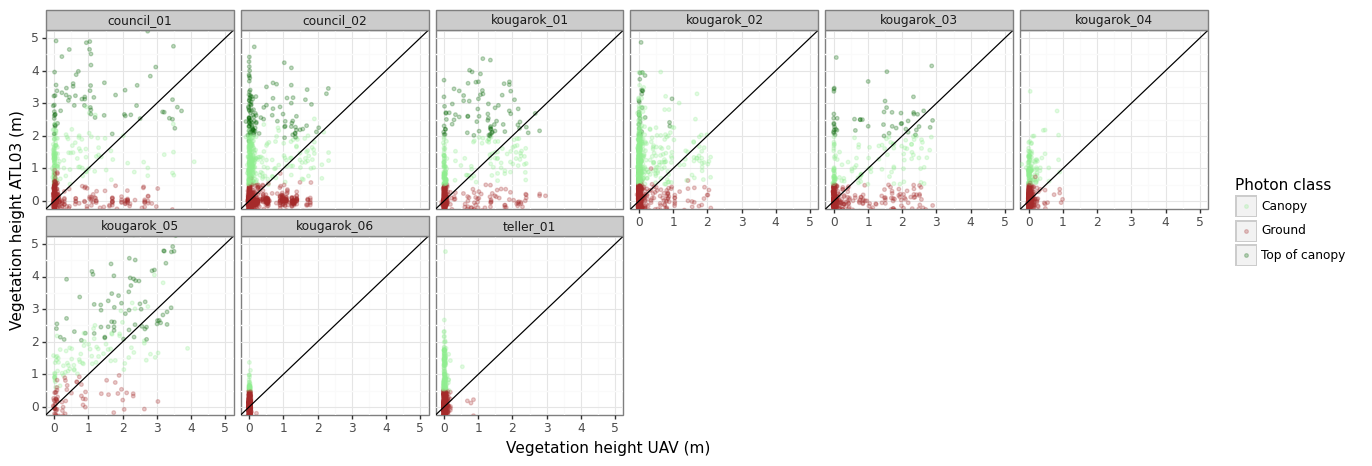

<ggplot: (1456195900130)>

In [294]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(all_ref_gdf_extract[(all_ref_gdf_extract.dsm_uav !=-10000) & (all_ref_gdf_extract.type_ref == 'ATL03')], aes(y='height_ref', x='ht_uav'))
        + labs(x = 'Vegetation height UAV (m)', y= 'Vegetation height ATL03 (m)')
        #+ geom_bin2d(binwidth=0.2)
        + custom_color_atl03
        + geom_point(aes(color='class_name', group='class_name'), size=1, alpha=0.25)
        + geom_abline()
        + facet_wrap(' ~ site', ncol=6)#, scales = 'free_x')
    + coord_cartesian(xlim = (0,5), ylim = (0,5))
    + theme_bw() 
)

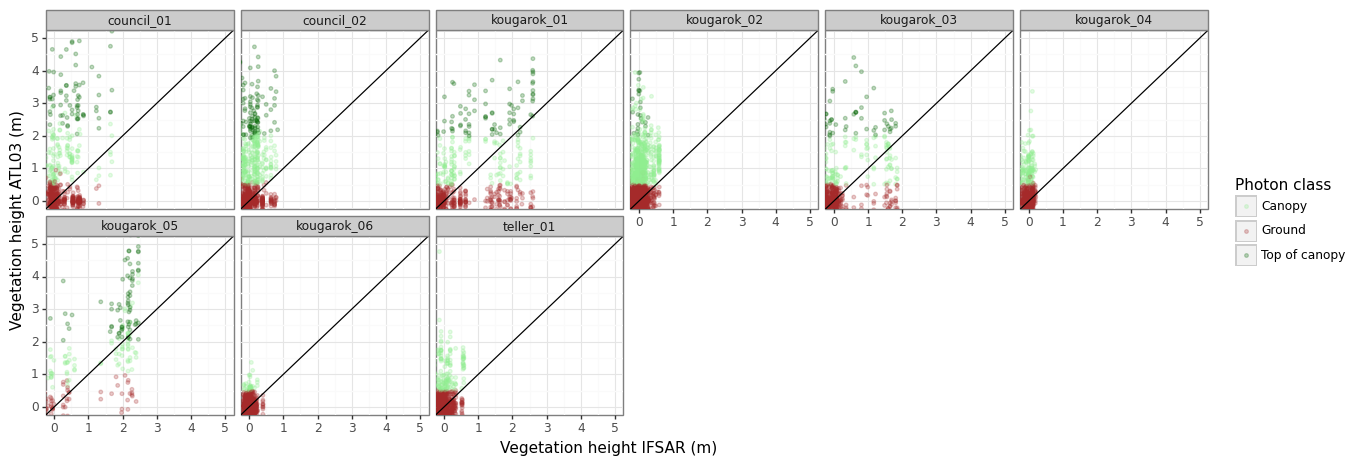

<ggplot: (1435783560132)>

In [141]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(all_ref_gdf_extract[(all_ref_gdf_extract.dsm_uav !=-10000) & (all_ref_gdf_extract.type_ref == 'ATL03')], aes(y='height_ref', x='ht_ifsar'))
        + labs(x = 'Vegetation height IFSAR (m)', y= 'Vegetation height ATL03 (m)')
        #+ geom_bin2d(binwidth=0.2)
        + custom_color_atl03
        + geom_point(aes(color='class_name', group='class_name'), size=1, alpha=0.25)
        + geom_abline()
        + facet_wrap(' ~ site', ncol=6)#, scales = 'free_x')
    + coord_cartesian(xlim = (0,5), ylim = (0,5))
    + theme_bw() 
)

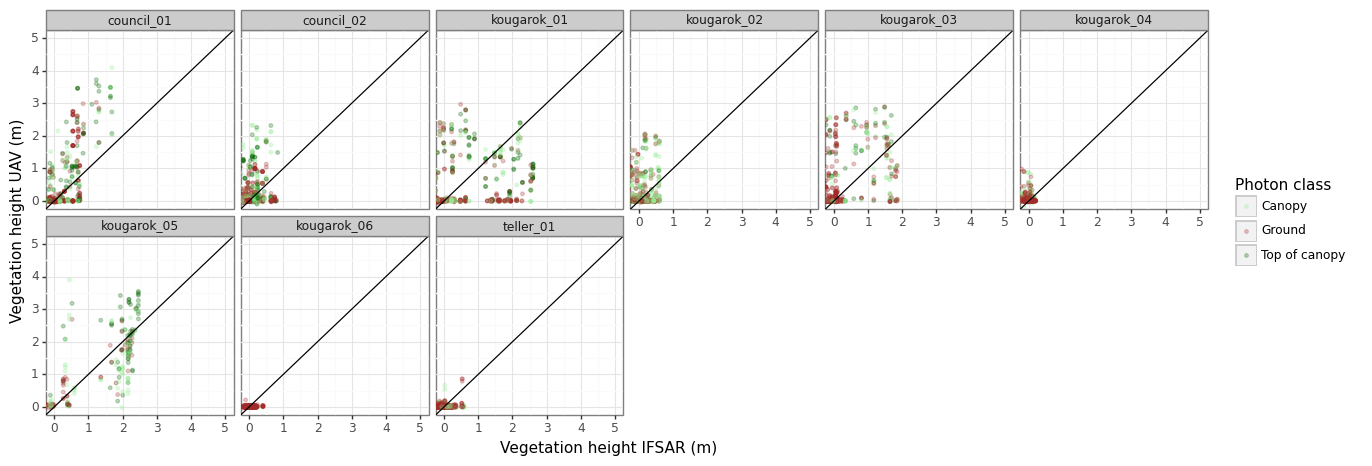

<ggplot: (1435783069648)>

In [142]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(all_ref_gdf_extract[(all_ref_gdf_extract.dsm_uav !=-10000) & (all_ref_gdf_extract.type_ref == 'ATL03')], aes(y='ht_uav', x='ht_ifsar'))
        + labs(x = 'Vegetation height IFSAR (m)', y= 'Vegetation height UAV (m)')
        #+ geom_bin2d(binwidth=0.2)
        + custom_color_atl03
        + geom_point(aes(color='class_name', group='class_name'), size=1, alpha=0.25)
        + geom_abline()
        + facet_wrap(' ~ site', ncol=6)#, scales = 'free_x')
    + coord_cartesian(xlim = (0,5), ylim = (0,5))
    + theme_bw() 
)

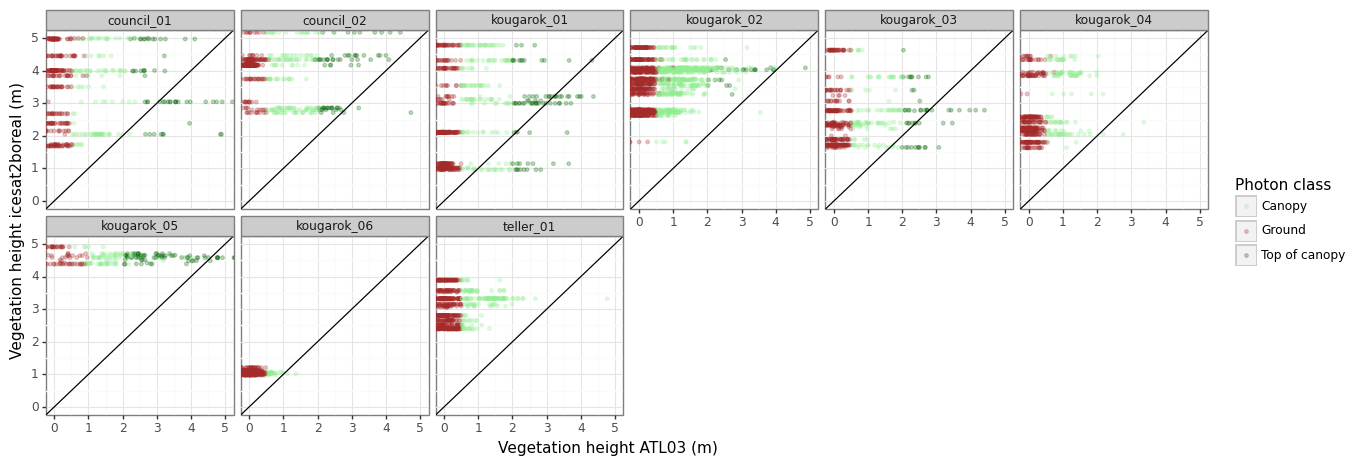

<ggplot: (1435887062176)>

In [145]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(all_ref_gdf_extract[(all_ref_gdf_extract.dsm_uav !=-10000) & (all_ref_gdf_extract.type_ref == 'ATL03')], aes(y='ht_icesat2boreal', x='height_ref'))
        + labs(x = 'Vegetation height ATL03 (m)', y= 'Vegetation height icesat2boreal (m)')
        #+ geom_bin2d(binwidth=0.2)
        + custom_color_atl03
        + geom_point(aes(color='class_name', group='class_name'), size=1, alpha=0.25)
        + geom_abline()
        + facet_wrap(' ~ site', ncol=6)#, scales = 'free_x')
    + coord_cartesian(xlim = (0,5), ylim = (0,5))
    + theme_bw() 
)

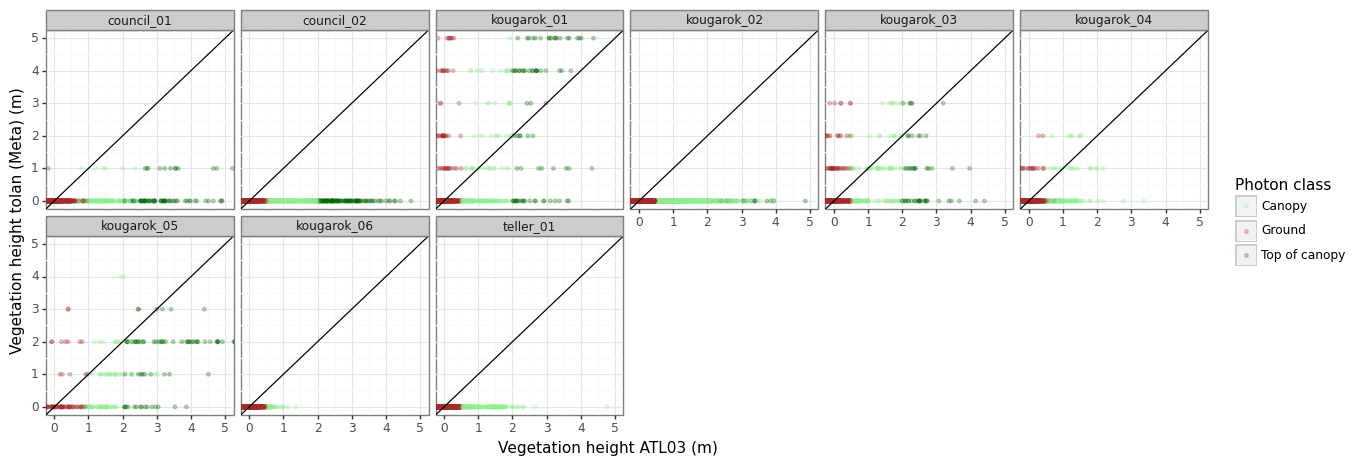

<ggplot: (1435779373873)>

In [146]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(all_ref_gdf_extract[(all_ref_gdf_extract.dsm_uav !=-10000) & (all_ref_gdf_extract.type_ref == 'ATL03')], aes(y='ht_tolan', x='height_ref'))
        + labs(x = 'Vegetation height ATL03 (m)', y= 'Vegetation height tolan (Meta) (m)')
        #+ geom_bin2d(binwidth=0.2)
        + custom_color_atl03
        + geom_point(aes(color='class_name', group='class_name'), size=1, alpha=0.25)
        + geom_abline()
        + facet_wrap(' ~ site', ncol=6)#, scales = 'free_x')
    + coord_cartesian(xlim = (0,5), ylim = (0,5))
    + theme_bw() 
)

In [220]:
all_ref_gdf_extract.columns.to_list()

['type_ref',
 'class',
 'site',
 'beam',
 'doy',
 'x',
 'y',
 'elev',
 'height_ref',
 'geometry',
 'class_name',
 'color',
 'dsm_uav',
 'dtm_uav',
 'ht_uavchm030',
 'ht_uavchm200',
 'dsm_ifsar',
 'dtm_ifsar',
 'ht_boreal_H30_2020',
 'ht_boreal_S1H30_2020',
 'ht_tolan',
 'ht_lang',
 'ht_potapov',
 'ht_nasa_cnn_10m',
 'ht_20110727_103001000D914900cnn-chm-v1_v1',
 'ht_20120721_103001001AB23900cnn-chm-v1_v1',
 'ht_20160817_103001005B484100cnn-chm-v1_v1',
 'ht_20190820_10300100954DE000cnn-chm-v1_v1',
 'ht_20190820_10300100968FB300cnn-chm-v1_v1',
 'ht_20190820_1030010099BF2F00cnn-chm-v1_v1',
 'ht_20200722_10300100AB1FD100cnn-chm-v1_v1',
 'ht_20170719_104001002F7A2E00cnn-chm-v1_v1',
 'ht_20190822_104001005054F700cnn-chm-v1_v1',
 'ht_20200704_104001005EADB900cnn-chm-v1_v1',
 'ht_20110727_103001000D914900chm_dinov2-chm-v1',
 'ht_20160817_103001005B484100chm_dinov2-chm-v1',
 'ht_20190820_10300100954DE000chm_dinov2-chm-v1',
 'ht_20190820_10300100968FB300chm_dinov2-chm-v1',
 'ht_20190820_103001009

### Melt `ATL03` to get a height dataframe

In [226]:
atl03_m = pd.melt(atl03_field_gdf_extract[atl03_field_gdf_extract.class_name != 'Ground'], id_vars=['height','class_name','color','year', 'doy','site'], value_vars = atl03_field_gdf_extract.filter(like='ht').columns.to_list() )
atl03_m.shape

NameError: name 'atl03_field_gdf_extract' is not defined

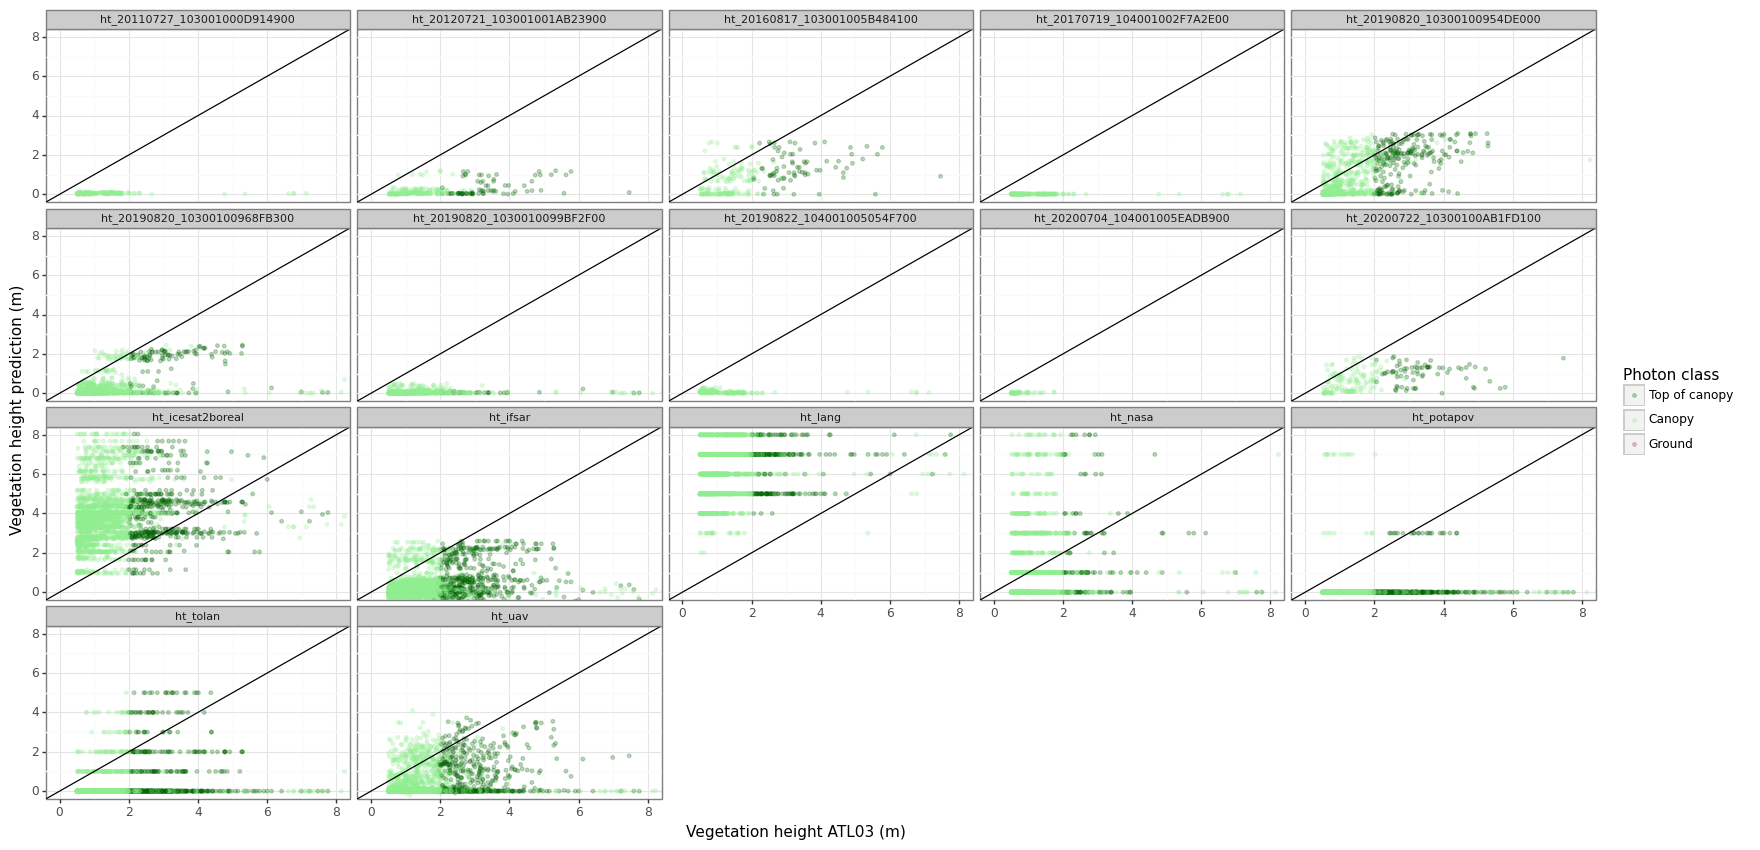

<ggplot: (1410255358079)>

In [63]:
plotnine.options.figure_size = (20, 10)

(
      ggplot(atl03_m[atl03_m.class_name != 'Ground'], aes(y='value', x='height', group='variable'))
        + labs(x = 'Vegetation height ATL03 (m)', y= 'Vegetation height prediction (m)')
        #+ geom_bin2d(binwidth=0.2)
    + scale_color_manual(values = class_color_list, labels=class_name_list, name='Photon class')
    + geom_point(aes(color='class_name'), size=1, alpha=0.25)
    #+ geom_bin2d(binwidth=0.5)
    #atl03_m.type == 'ATL03'
        + geom_abline()
        #+ facet_grid(' variable ~ site + year + doy')#, scales = 'free_x')
    + facet_wrap('~variable', ncol=5)
    + coord_cartesian(xlim = (0,8), ylim = (0,8))
    + theme_bw() 
    + theme(strip_text_x = element_text(size=8))
)

In [54]:
num_ht_rasters = len(atl03_m.groupby('variable').groups.keys())

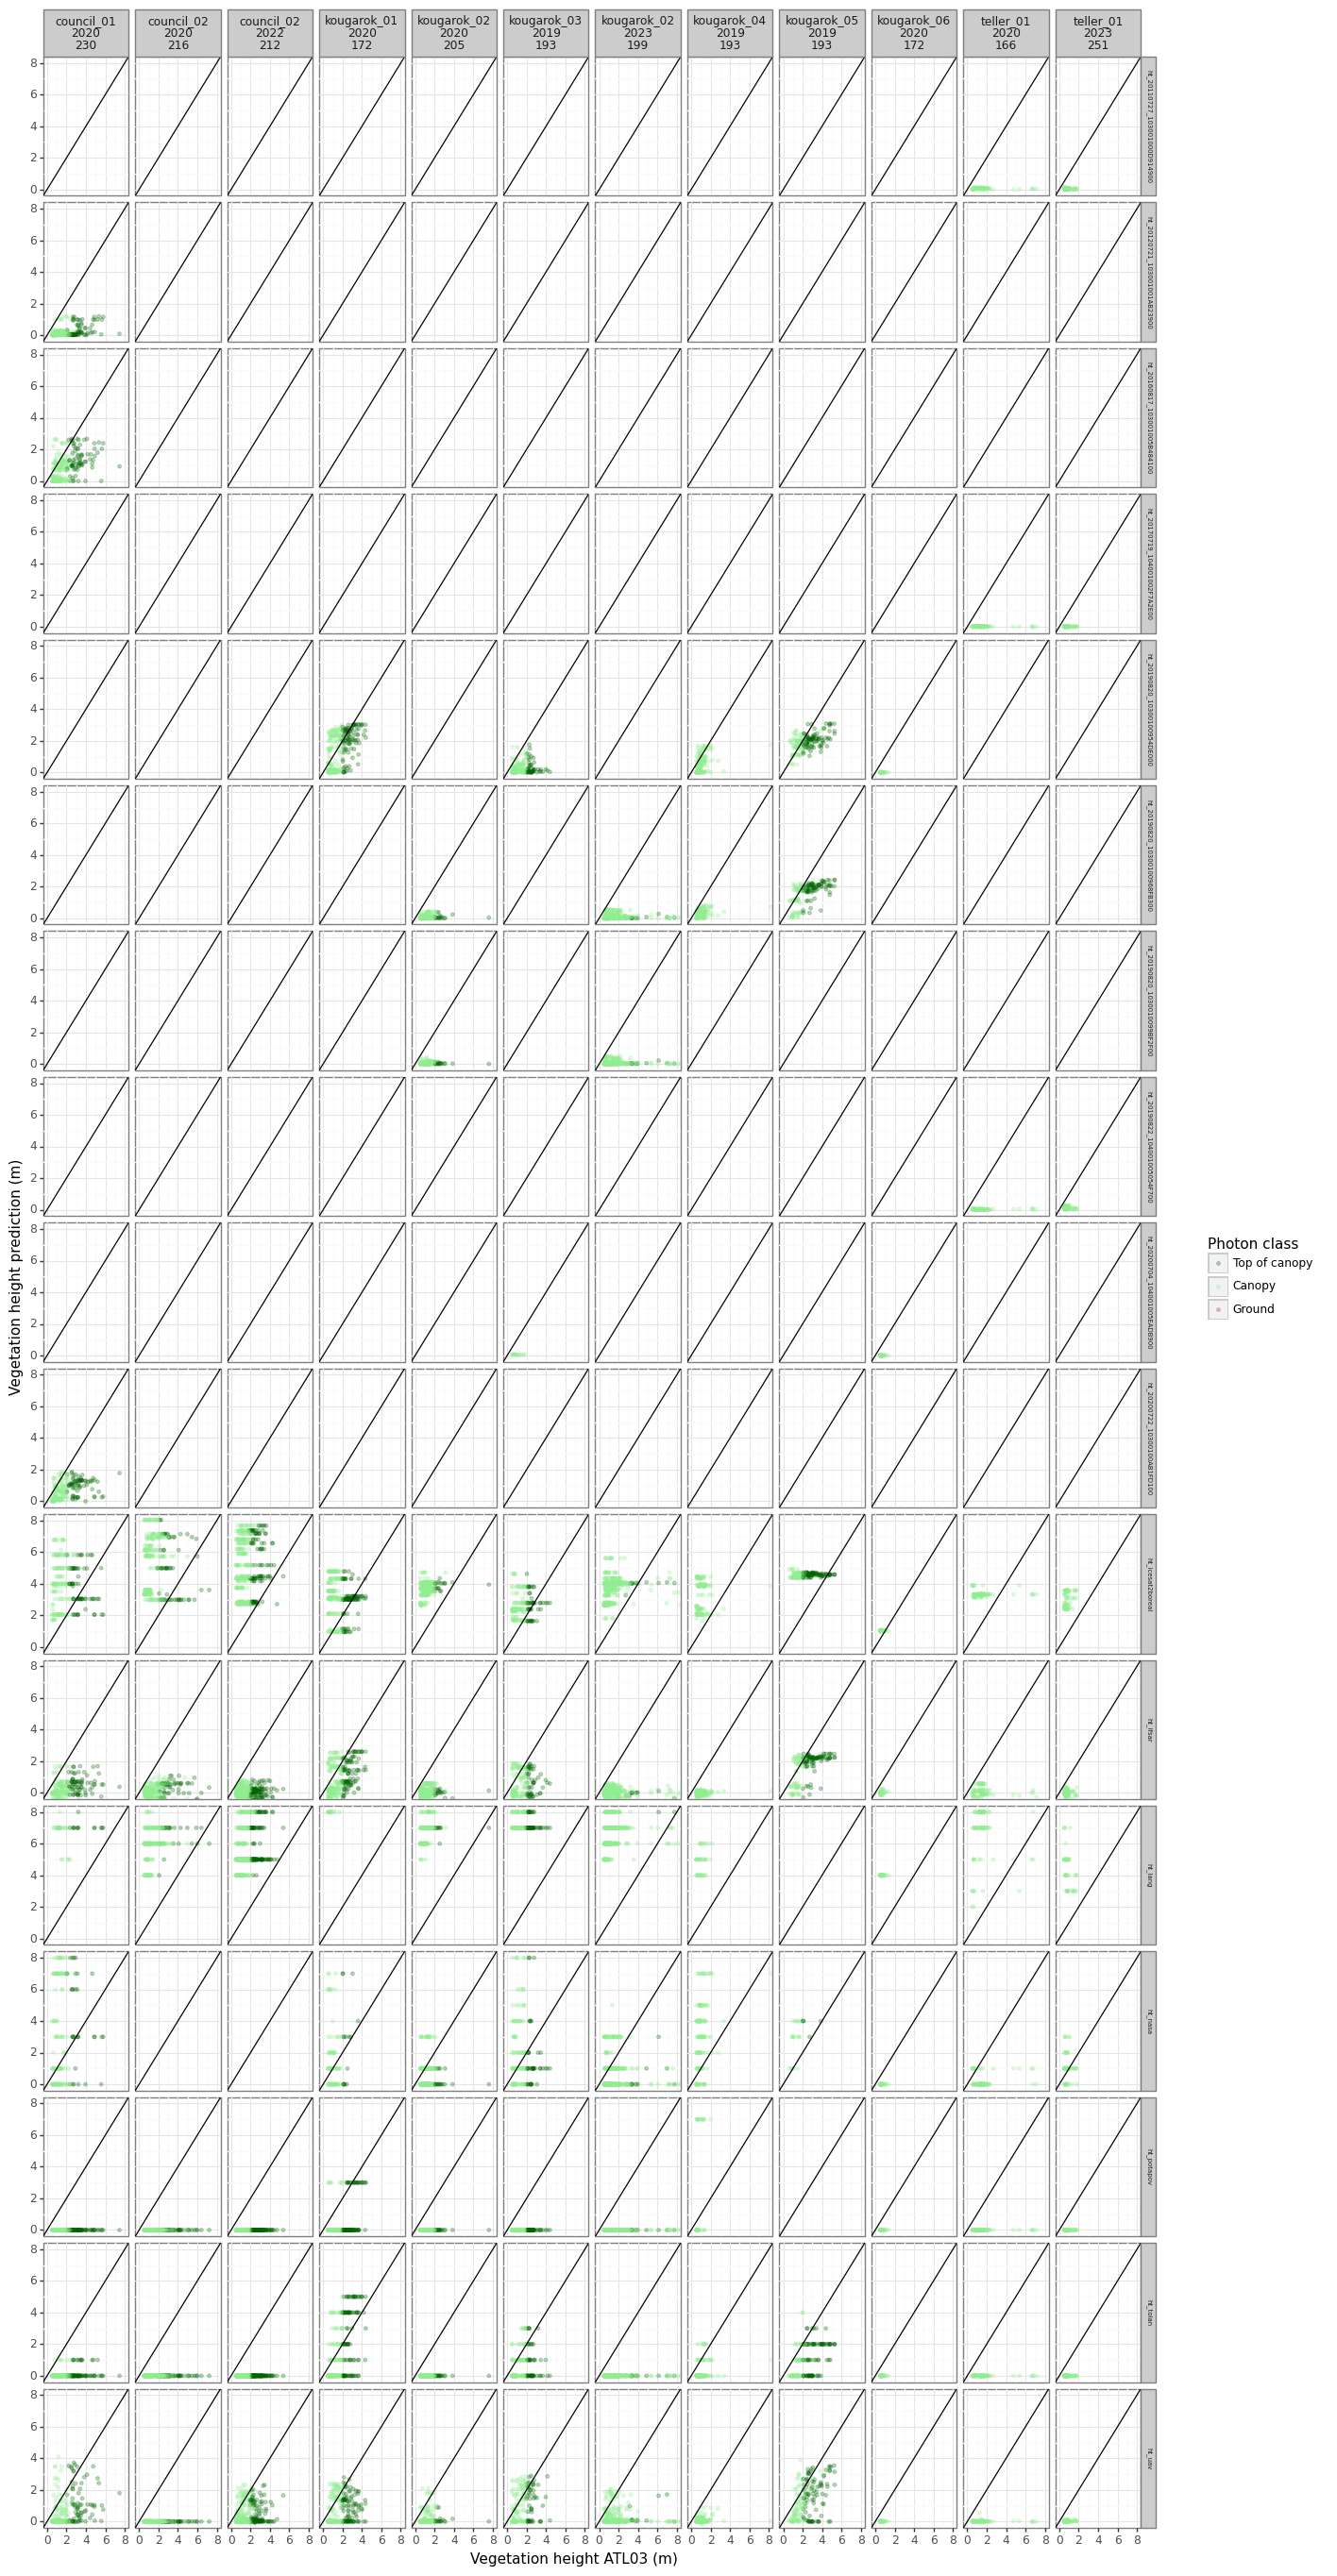

<ggplot: (1410279271415)>

In [64]:
plotnine.options.figure_size = (15, 2*num_ht_rasters)

(
      ggplot(atl03_m[atl03_m.class_name != 'Ground'], aes(y='value', x='height', group='variable'))
        + labs(x = 'Vegetation height ATL03 (m)', y= 'Vegetation height prediction (m)')
        #+ geom_bin2d(binwidth=0.2)
    + scale_color_manual(values = class_color_list, labels=class_name_list, name='Photon class')
    + geom_point(aes(color='class_name'), size=1, alpha=0.25)
    #+ geom_bin2d(binwidth=0.5)
    #+ scale_fill_cmap(name = "count", trans = "log", cmap_name = 'plasma',
     #                   breaks = [1, 10,25,50,150], labels = [1, 10,25,50,150])
        + geom_abline()
        + facet_grid(' variable ~ site + year + doy')#, scales = 'free_x')
    + coord_cartesian(xlim = (0,8), ylim = (0,8))
    + theme_bw() 
    + theme(strip_text_y = element_text(size=5))
)

### Melt `Field` to get a height dataframe

In [296]:
field_m = pd.melt(field_ref_gdf_extract, id_vars=['height_cm_200cm','species_200cm','site'], value_vars = field_ref_gdf_extract.filter(regex='^ht_').columns.to_list() )
field_m['height_m_2m'] = field_m['height_cm_200cm'] / 100.
field_m.dropna().shape

NameError: name 'field_ref_gdf_extract' is not defined

In [287]:
field_m.dropna().head()

height_cm_200cm species_200cm        site          variable     value  \
0            204.0        salala  council_01  ht_icesat2boreal  2.047952   
1            225.0        salala  council_01  ht_icesat2boreal  2.047952   
2            368.0        salala  council_01  ht_icesat2boreal  2.047952   
3            428.0        salala  council_01  ht_icesat2boreal  2.047952   
4            394.0        salala  council_01  ht_icesat2boreal  2.047952   

   height_m_2m  
0         2.04  
1         2.25  
2         3.68  
3         4.28  
4         3.94

In [229]:
num_ht_rasters = len(field_m.dropna().groupby('variable').groups.keys())
num_ht_rasters

16

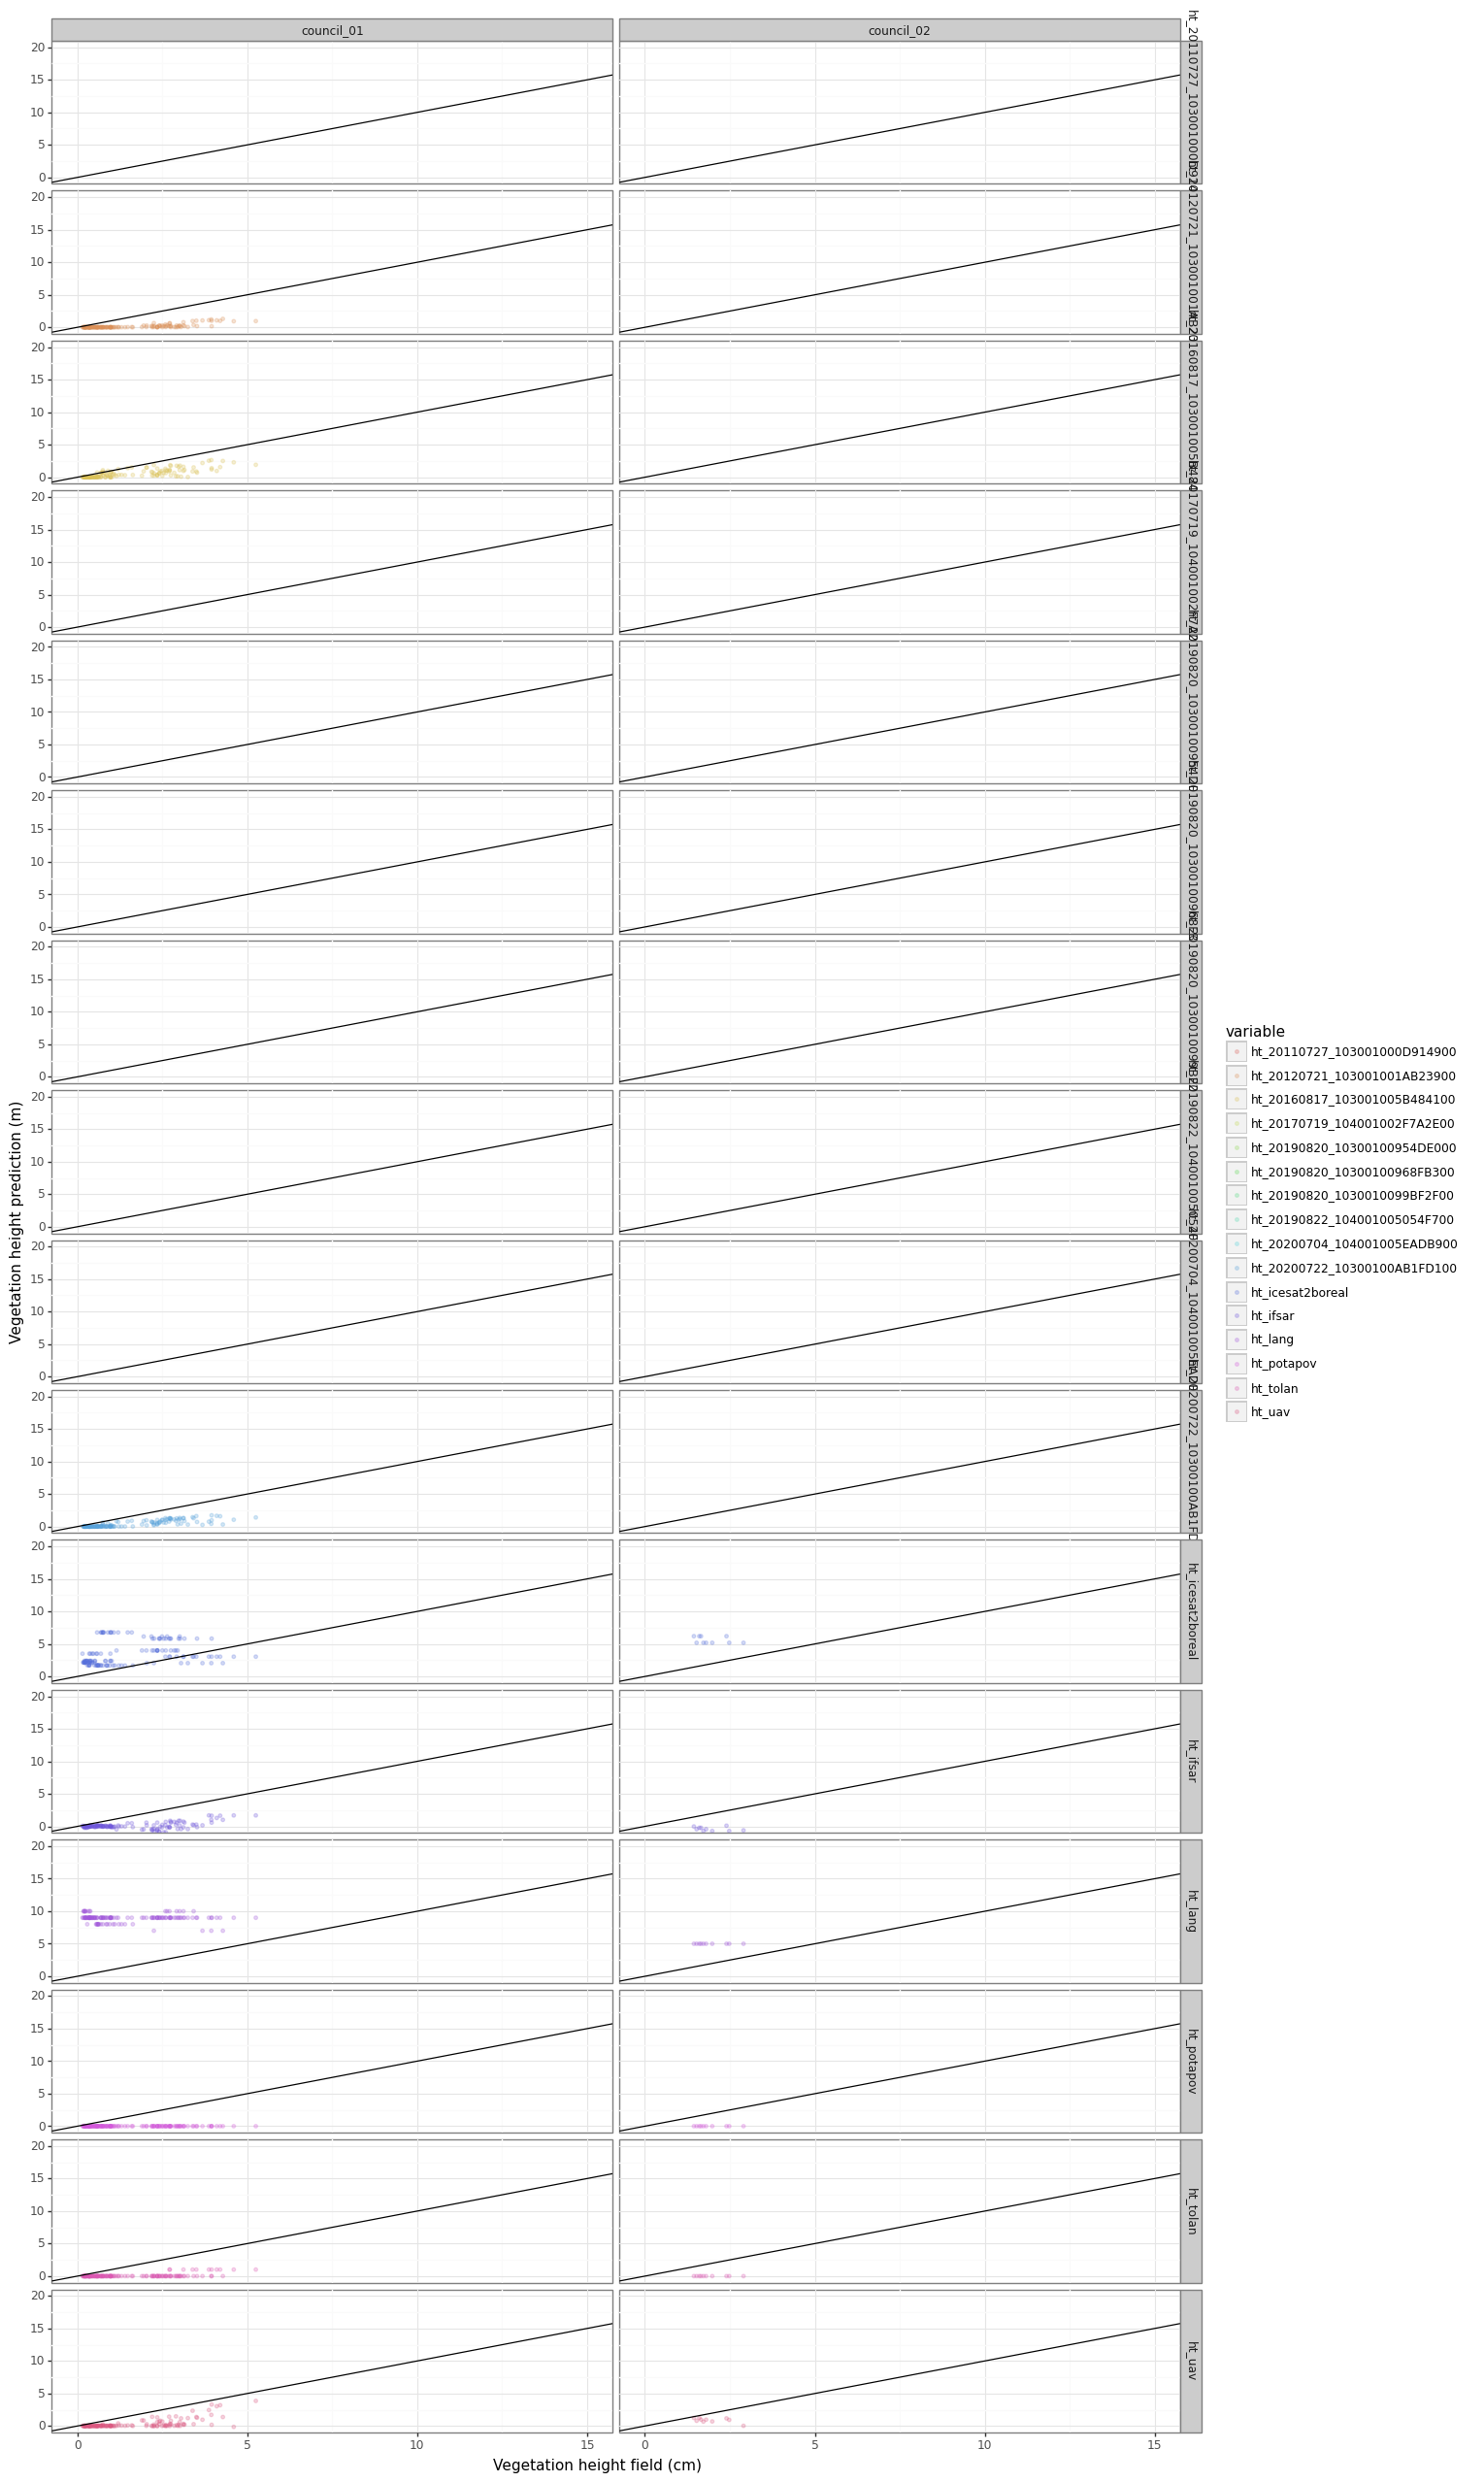

<ggplot: (1435097355129)>

In [228]:
plotnine.options.figure_size = (15, 2*num_ht_rasters)

(
      ggplot(field_m.dropna(), aes(y='value', x='height_m_2m', group='variable'))
        + labs(x = 'Vegetation height field (cm)', y= 'Vegetation height prediction (m)')
        #+ geom_bin2d(binwidth=0.2)
        #+ scale_color_manual(values = class_color_list, labels=class_name_list, name='Photon class')
    + geom_point(aes(color='variable'), size=1, alpha=0.25)
    #+ geom_bin2d(binwidth=0.5)
    #+ scale_fill_cmap(name = "count", trans = "log", cmap_name = 'plasma',
                        #breaks = [1, 10,25,50,150], labels = [1, 10,25,50,150]
     #                )
        + geom_abline()
    + facet_grid(' variable ~ site')#, scales = 'free_x')
    + coord_cartesian(xlim = (0,15), ylim = (0,20))
    + theme_bw() 
)

In [224]:
plotnine.options.figure_size = (15, 2*5)

(
      ggplot(field_m.dropna(), aes(y='value', x='height_m_2m', group='variable'))
        + labs(x = 'Vegetation height field (cm)', y= 'Vegetation height prediction (m)')
        #+ geom_bin2d(binwidth=0.2)
        #+ scale_color_manual(values = class_color_list, labels=class_name_list, name='Photon class')
        #+ geom_point(aes(color='variable'), size=1, alpha=0.25)
    + geom_bin2d(binwidth=0.5)
    + scale_fill_cmap(name = "count", trans = "log", cmap_name = 'plasma',
                        #breaks = [1, 10,25,50,150], labels = [1, 10,25,50,150]
                     )
        + geom_abline()
        + facet_grid(' variable ~ site')#, scales = 'free_x')
    + coord_cartesian(xlim = (0,15), ylim = (0,20))
    + theme_bw() 
)


KeyboardInterrupt



## Plot transects of height & elevation by site
#### TODO: shift ATL08 to align correctly with ATL03 along the transect
#### TODO: put UAV into same vertical datum as ICESat-2
#### TODO: find missing ATL08 30 for a couple lines

In [240]:
#atl08_30m_field_gdf_extract[atl08_30m_field_gdf_extract.site == 'teller_01'].h_canopy

In [241]:
#atl08_30m_field_gdf_extract[(atl08_30m_field_gdf_extract.site == 'teller_01') & (atl08_30m_field_gdf_extract.dsm_uav != -10000)].h_canopy

In [242]:
#atl08_30m_field_gdf_extract[(atl08_30m_field_gdf_extract.site == 'teller_01') & (atl08_30m_field_gdf_extract.dsm_uav != -10000)]#.height_uav

In [243]:
# atl08_30m_field_gdf_extract[(atl08_30m_field_gdf_extract.site == 'teller_01') 
#                             #& (atl08_30m_field_gdf_extract.dsm_uav != -10000)
#                            ].doy#.height_uav

In [244]:
#atl08_field_gdf_extract[atl08_field_gdf_extract.site == 'teller_01'].h_can

In [245]:
#atl08_field_gdf.columns

In [246]:
#atl08_field_gdf_extract[(atl08_field_gdf_extract.site == 'teller_01') & (atl08_field_gdf_extract.dsm_uav != -10000)].h_can

In [247]:
#atl08_field_gdf_extract[(atl08_field_gdf_extract.site == 'teller_01') & (atl08_field_gdf_extract.dsm_uav != -10000)].height_uav

In [227]:
field_ref_gdf.head()

parent_id        site line_id  point_id  child_id point_distance_m  \
0  747fe077  council_01      01       1.0  890dd23d                2   
1  747fe077  council_01      01       2.0  8c6deb6c                4   
2  747fe077  council_01      01       3.0  087022c1                6   
3  747fe077  council_01      01       4.0  f2e76519                8   
4  747fe077  council_01      01       5.0  cb9f1f25               10   

  species_top_hit  height_cm_30cm species_30cm  height_cm_200cm species_200cm  \
0          salala           174.0       salala            204.0        salala   
1          salala           142.0       salala            225.0        salala   
2          salala           189.0       salala            368.0        salala   
3          salala           273.0       salala            428.0        salala   
4          salala           371.0      salpul1            394.0        salala   

  species_top_hit_agg    species_30cm_agg species_200cm_agg  \
0     Feltleaf willow     Feltleaf willow   Feltleaf willow   
1     Feltleaf willow     Feltleaf willow   Feltleaf willow   
2     Feltleaf willow     Feltleaf willow   Feltleaf willow   
3     Feltleaf willow     Feltleaf willow   Feltleaf willow   
4     Feltleaf willow  Diamondleaf willow   Feltleaf willow   

  species_top_hit_orig species_30cm_orig species_200cm_orig  \
0               salala            salala             salala   
1               salala            salala             salala   
2               salala            salala             salala   
3               salala            salala             salala   
4               salala           salpul1             salala   

             point_datetime          point_location  \
0 2024-08-12 12:01:01+00:00  64.696942, -164.187048   
1 2024-08-12 12:01:46+00:00  64.696947, -164.187052   
2 2024-08-12 12:02:44+00:00  64.696869, -164.187053   
3 2024-08-12 12:03:32+00:00  64.696867, -164.187071   
4 2024-08-12 12:04:21+00:00  64.696797, -164.187105   

                      geometry  
0  POINT (-164.18714 64.69692)  
1  POINT (-164.18714 64.69690)  
2  POINT (-164.18715 64.69689)  
3  POINT (-164.18715 64.69687)  
4  POINT (-164.18715 64.69685)

In [228]:
#atl03_field_gdf_extract.columns
import contextily as ctx

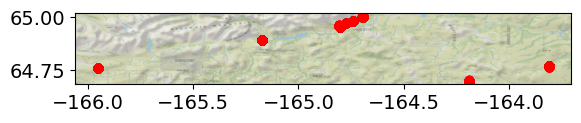

In [229]:
marker_kwds = {'marker_type':'circle','radius':3, 'fill':False}
ax = field_ref_gdf.drop('point_datetime', axis=1).to_crs(4326).plot(color='red')#marker_kwds=marker_kwds, tiles=basemaps['ESRINatGeo'].tiles, attr=' ')
ctx.add_basemap(ax = ax, source=basemaps['ESRINatGeo'].tiles, zoom=10, crs=4326 )

In [1]:
#field_ref_gdf.drop('point_datetime', axis=1).explore()

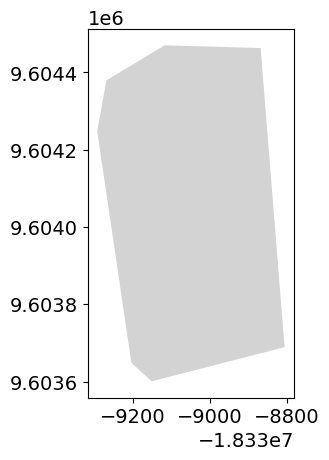

In [230]:
ax = footprint_uav_gdf[footprint_uav_gdf.site == 'kougarok_03'].to_crs(3857).plot(facecolor='lightgray')

In [231]:
import plotlib
import importlib
importlib.reload(plotlib)

<module 'plotlib' from '/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py'>

### Field x, y are NaN so get them from geometry field

In [232]:
import pyproj

all_ref_gdf_extract['x'] , all_ref_gdf_extract['y'] = pyproj.transform(pyproj.Proj(init='epsg:4326'), pyproj.Proj(init='epsg:6933'), all_ref_gdf_extract.geometry.x, all_ref_gdf_extract.geometry.y)
#tmp_x , tmp_y = pyproj.transform(pyproj.Proj(init='epsg:4326'), pyproj.Proj(init='epsg:6933'), all_ref_gdf_extract.head().geometry.x, all_ref_gdf_extract.head().geometry.y)

In [236]:
print(all_ref_gdf_extract.columns.to_list())

['type_ref', 'class', 'site', 'beam', 'doy', 'x', 'y', 'elev', 'height_ref', 'geometry', 'class_name', 'color', 'dsm_uav', 'dtm_uav', 'ht_uavchm030', 'ht_uavchm200', 'dsm_ifsar', 'dtm_ifsar', 'ht_boreal_H30_2020', 'ht_boreal_S1H30_2020', 'ht_tolan', 'ht_lang', 'ht_potapov', 'ht_nasa_cnn_10m', 'ht_20110727_103001000D914900cnn-chm-v1_v1', 'ht_20120721_103001001AB23900cnn-chm-v1_v1', 'ht_20160817_103001005B484100cnn-chm-v1_v1', 'ht_20190820_10300100954DE000cnn-chm-v1_v1', 'ht_20190820_10300100968FB300cnn-chm-v1_v1', 'ht_20190820_1030010099BF2F00cnn-chm-v1_v1', 'ht_20200722_10300100AB1FD100cnn-chm-v1_v1', 'ht_20170719_104001002F7A2E00cnn-chm-v1_v1', 'ht_20190822_104001005054F700cnn-chm-v1_v1', 'ht_20200704_104001005EADB900cnn-chm-v1_v1', 'ht_20110727_103001000D914900chm_dinov2-chm-v1', 'ht_20160817_103001005B484100chm_dinov2-chm-v1', 'ht_20190820_10300100954DE000chm_dinov2-chm-v1', 'ht_20190820_10300100968FB300chm_dinov2-chm-v1', 'ht_20190820_1030010099BF2F00chm_dinov2-chm-v1', 'ht_2020072

In [233]:
#all_ref_gdf_extract[(all_ref_gdf_extract.type_ref == 'field 2m')&(all_ref_gdf_extract.site == site) &(all_ref_gdf_extract.dsm_uav != -10000)].head()

kougarok_05


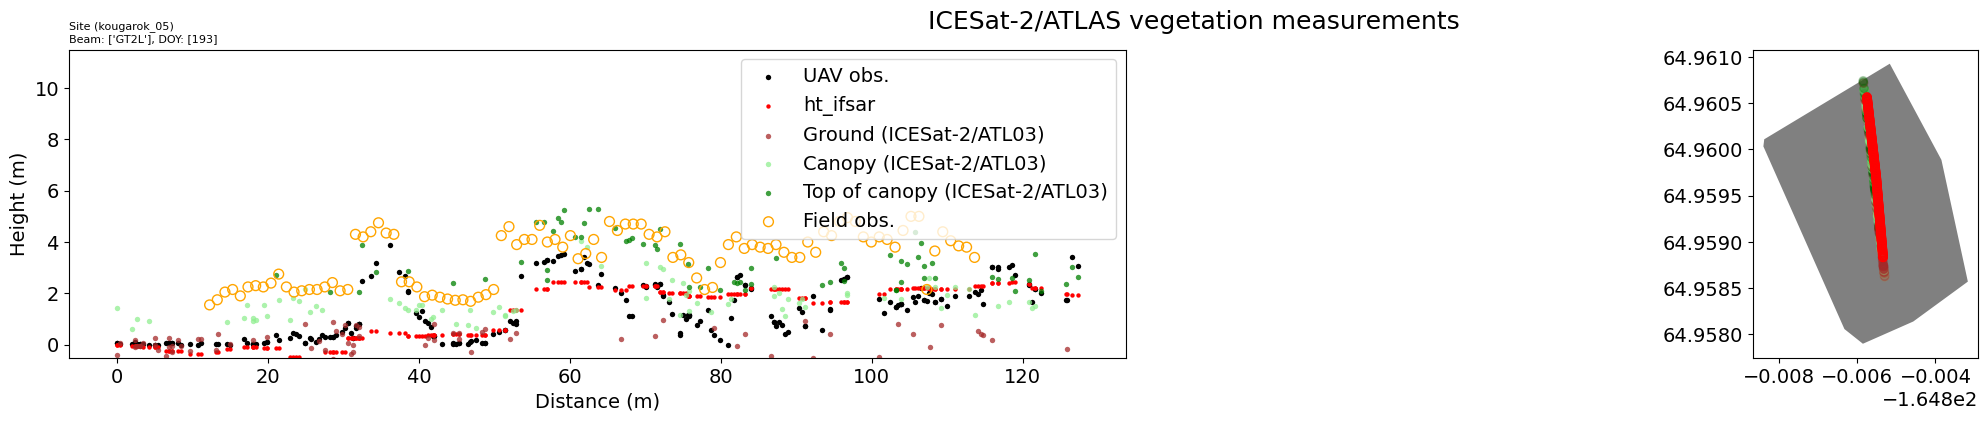

In [234]:
for site in ['kougarok_05']:
    print(site)
    # Remove rows where dsm values are NA
    #atl03_TMP = atl03_field_gdf[atl03_field_gdf.dsm_uav != -10000]
    plotlib.plot_atl03_transect(start=0, transect_length=50000, DO_HEIGHT=True, 
                                atl03_gdf=all_ref_gdf_extract[(all_ref_gdf_extract.type_ref == 'ATL03')&(all_ref_gdf_extract.site == site) &(all_ref_gdf_extract.dsm_uav != -10000)],
                                atl08_100m_gdf=None, #all_ref_gdf_extract[(all_ref_gdf_extract.type_ref == 'field 2m')&(all_ref_gdf_extract.site == site) &(all_ref_gdf_extract.dsm_uav != -10000)], #atl08_field_gdf_extract[(atl08_field_gdf_extract.site == site) ],#& (atl08_field_gdf_extract.dsm_uav != -10000)], 
                                # Fudging this - putting ref field pts in at atl08 30m slot
                                atl08_30m_gdf=all_ref_gdf_extract[
                                    (all_ref_gdf_extract.type_ref == 'field 2m') & 
                                    (all_ref_gdf_extract.site == site) & 
                                    (all_ref_gdf_extract.dsm_uav != -10000)
                                ], #atl08_30m_field_gdf_extract[(atl08_30m_field_gdf_extract.site == site) ],#& (atl08_30m_field_gdf_extract.dsm_uav != -10000)], 
                                footprint_uav_gdf=footprint_uav_gdf[footprint_uav_gdf.site == site],
                               site=site, PLOT_UAV=True, HEIGHT_COLS = ['ht_ifsar'], COL_ATL08_HT='height_ref',COL_ATL08_ELEV='elev', COL_ATL03_HT='height_ref', COL_UAV_HT='ht_uav')

In [261]:
import plotlib
import importlib
importlib.reload(plotlib)

<module 'plotlib' from '/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py'>

teller_01


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



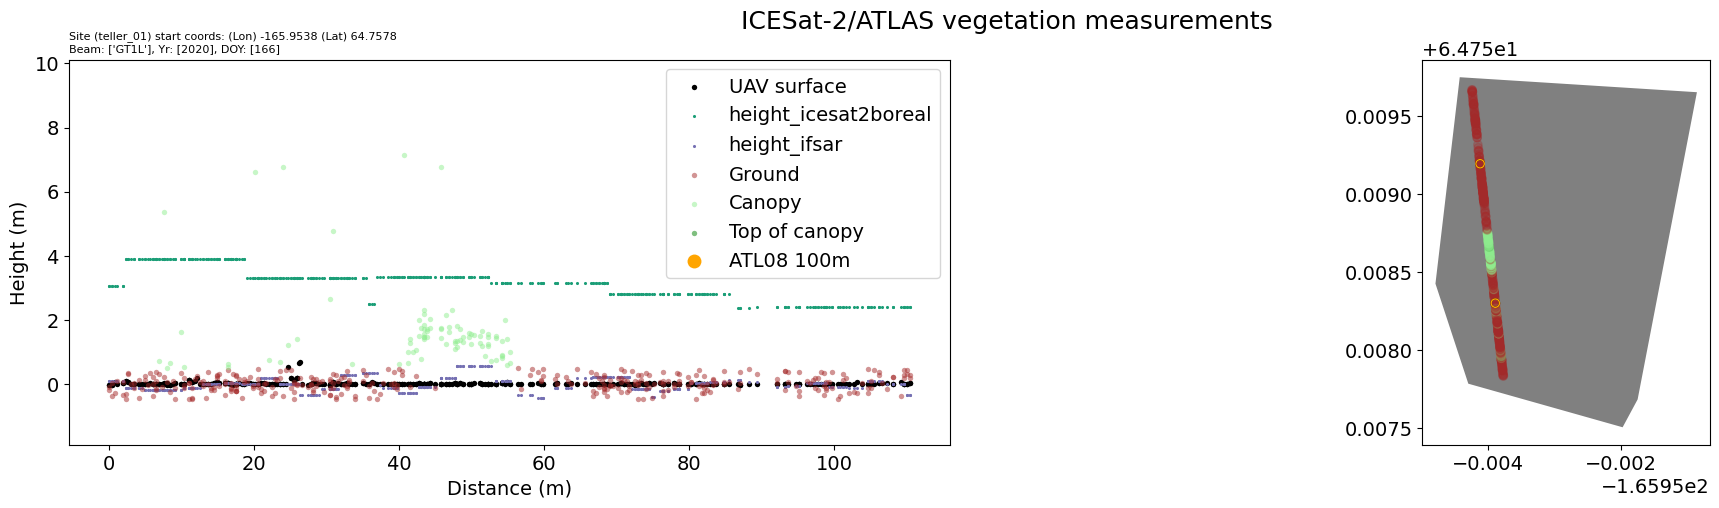

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



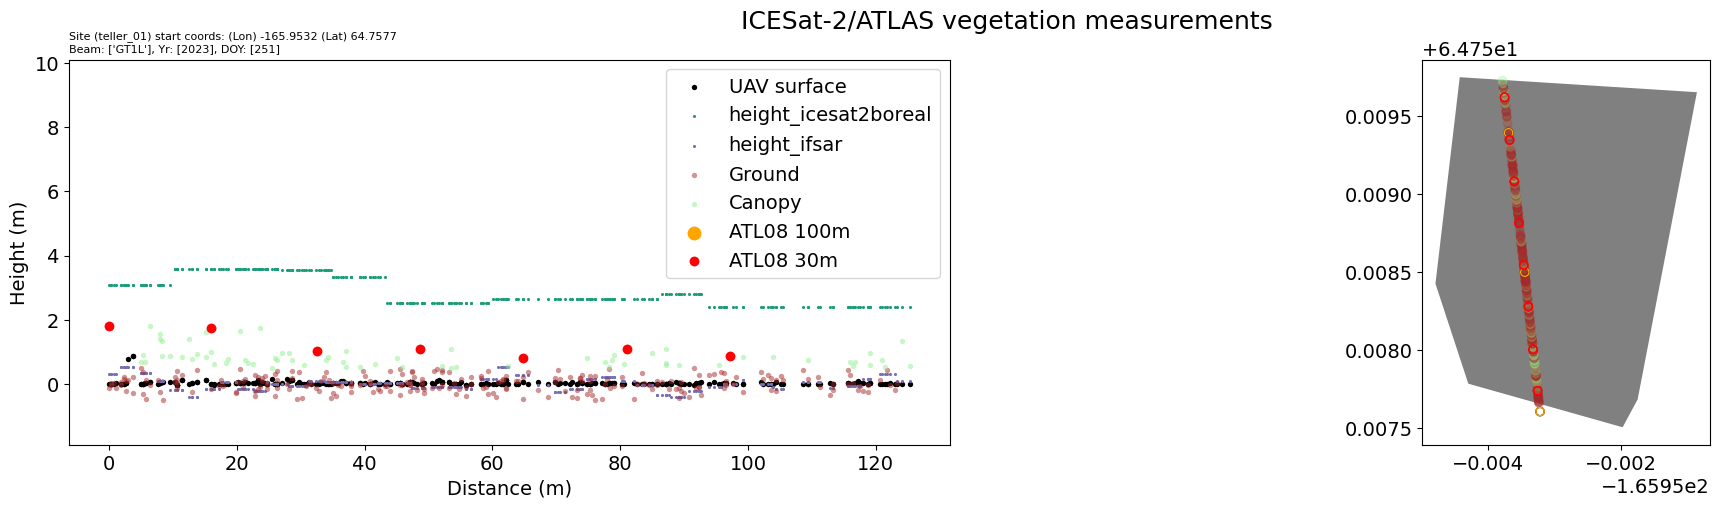

kougarok_06


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



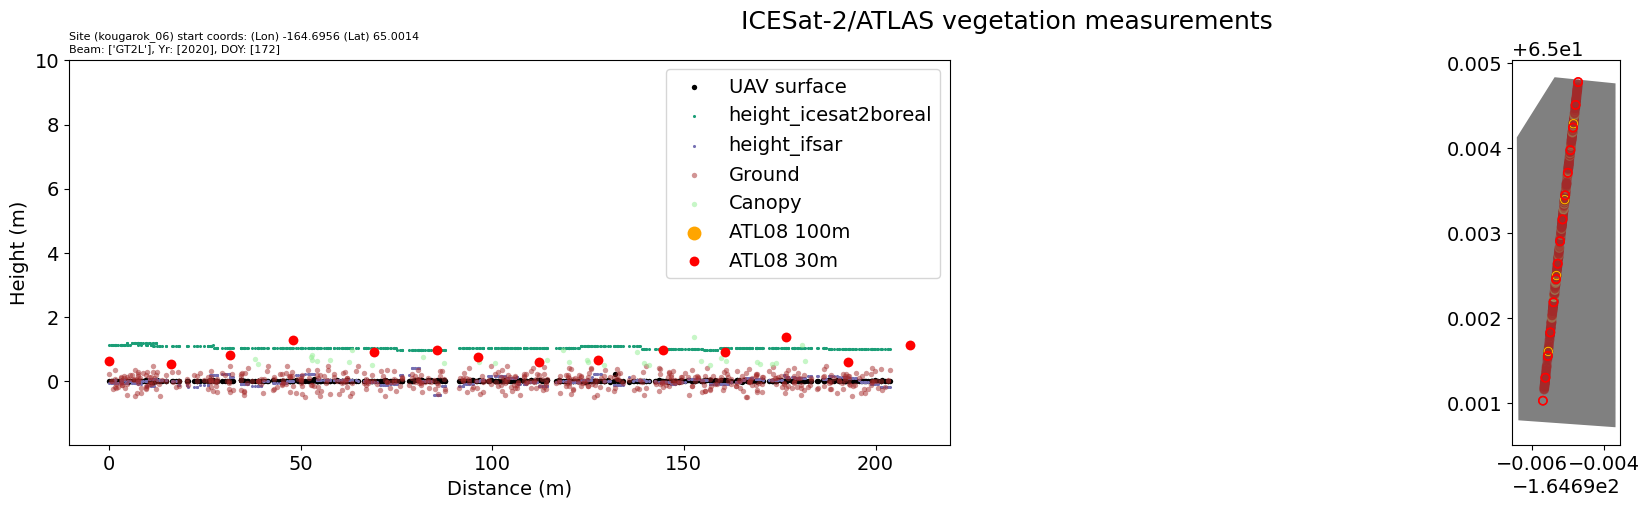

kougarok_05


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



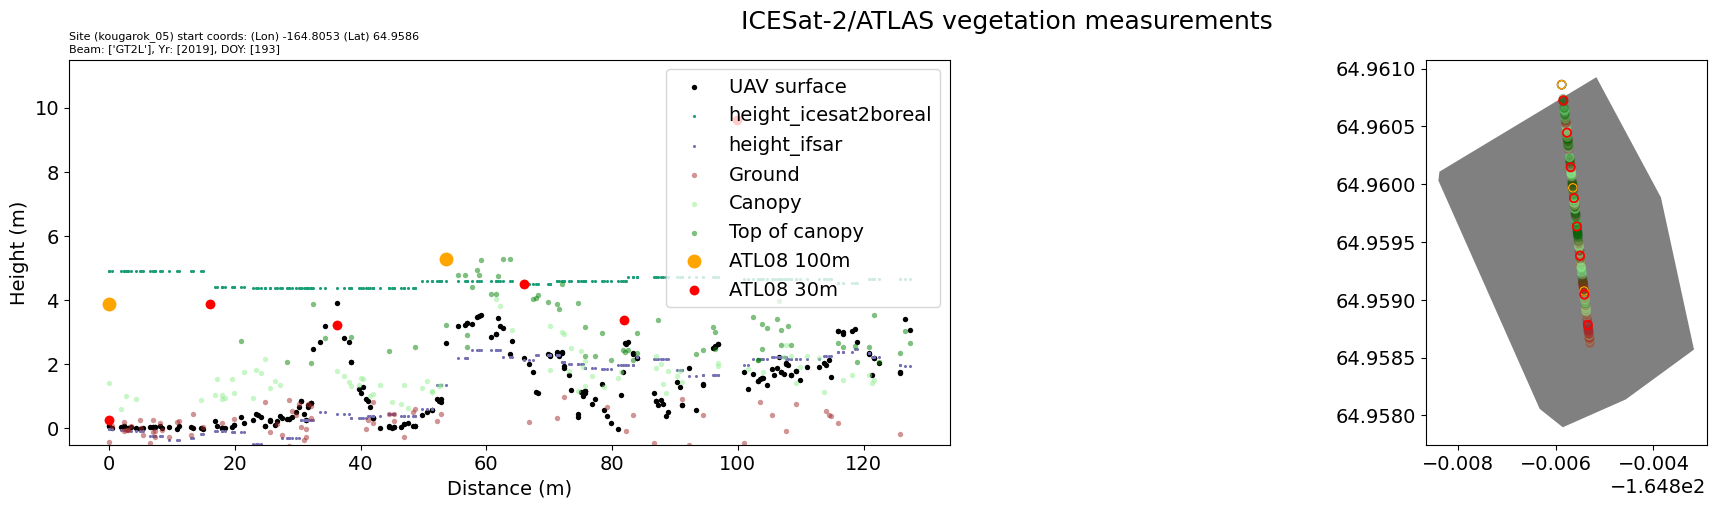

kougarok_04


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



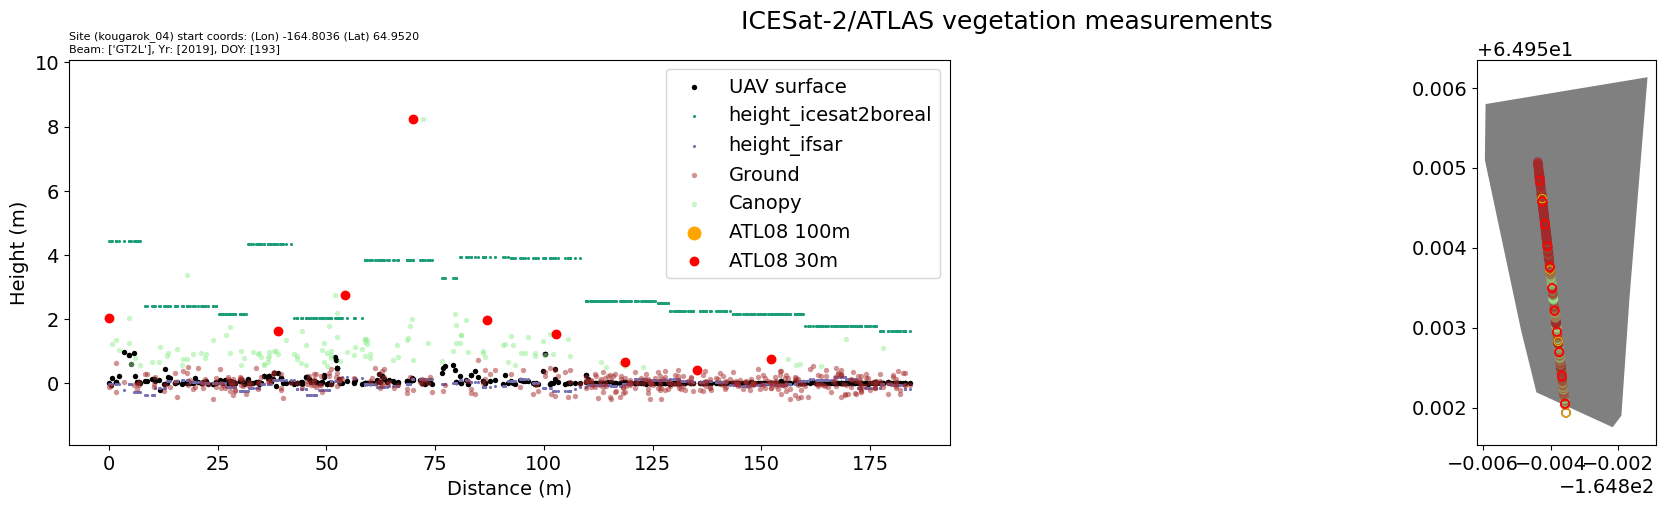

kougarok_03


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



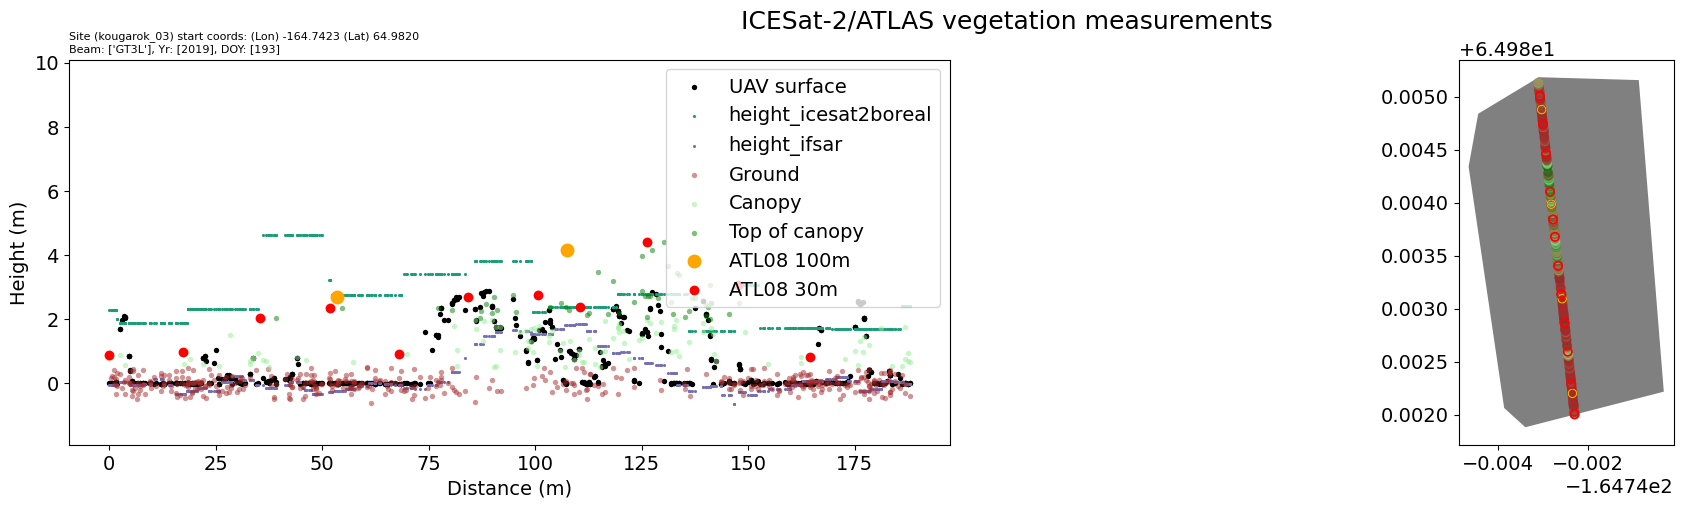

kougarok_02


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



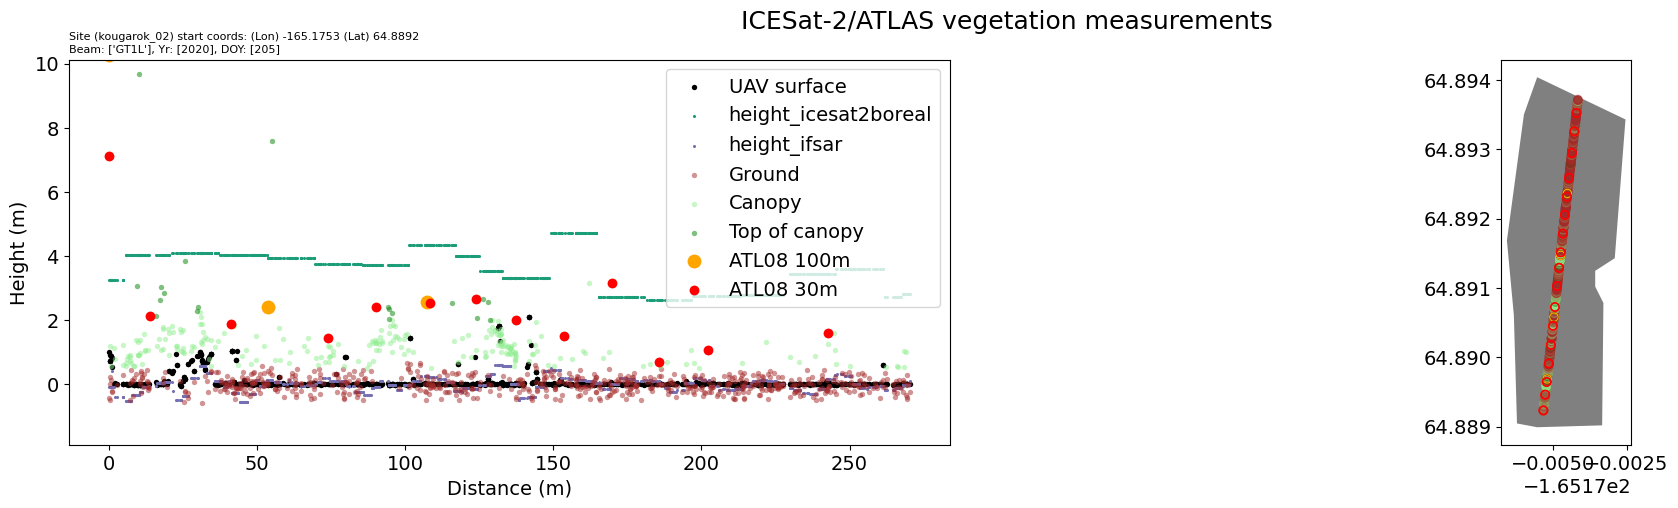

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



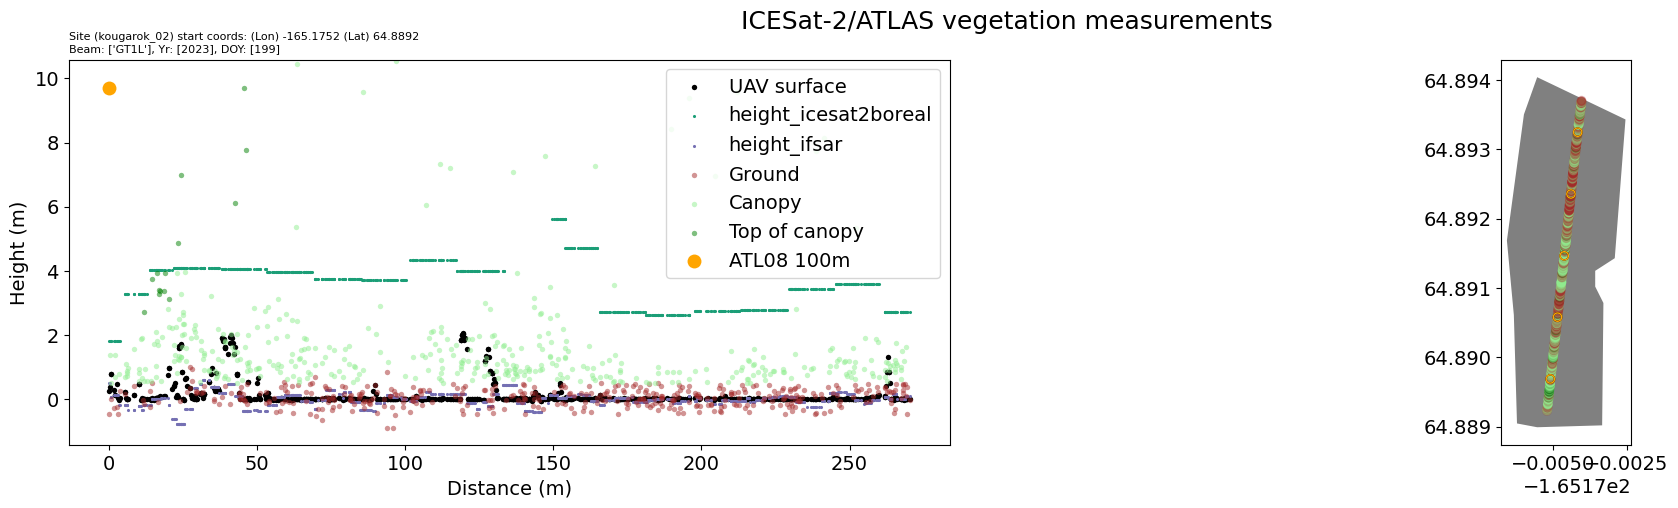

kougarok_01


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



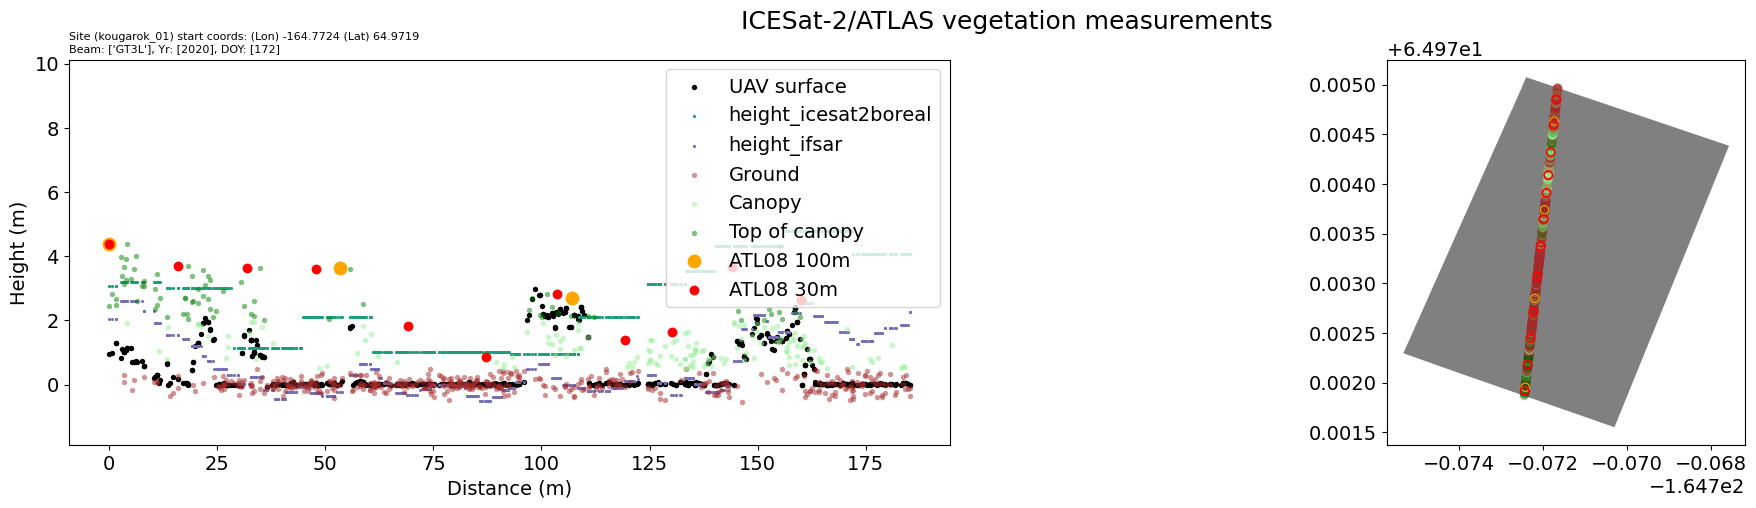

council_02


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



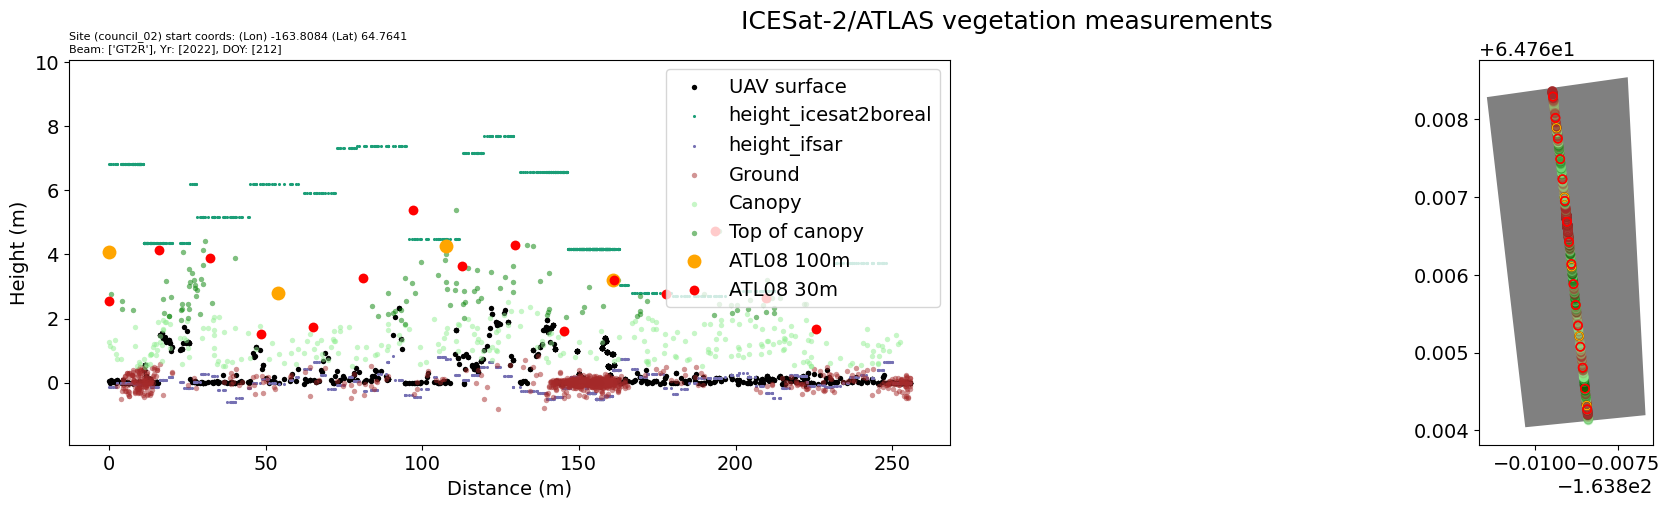

council_01


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



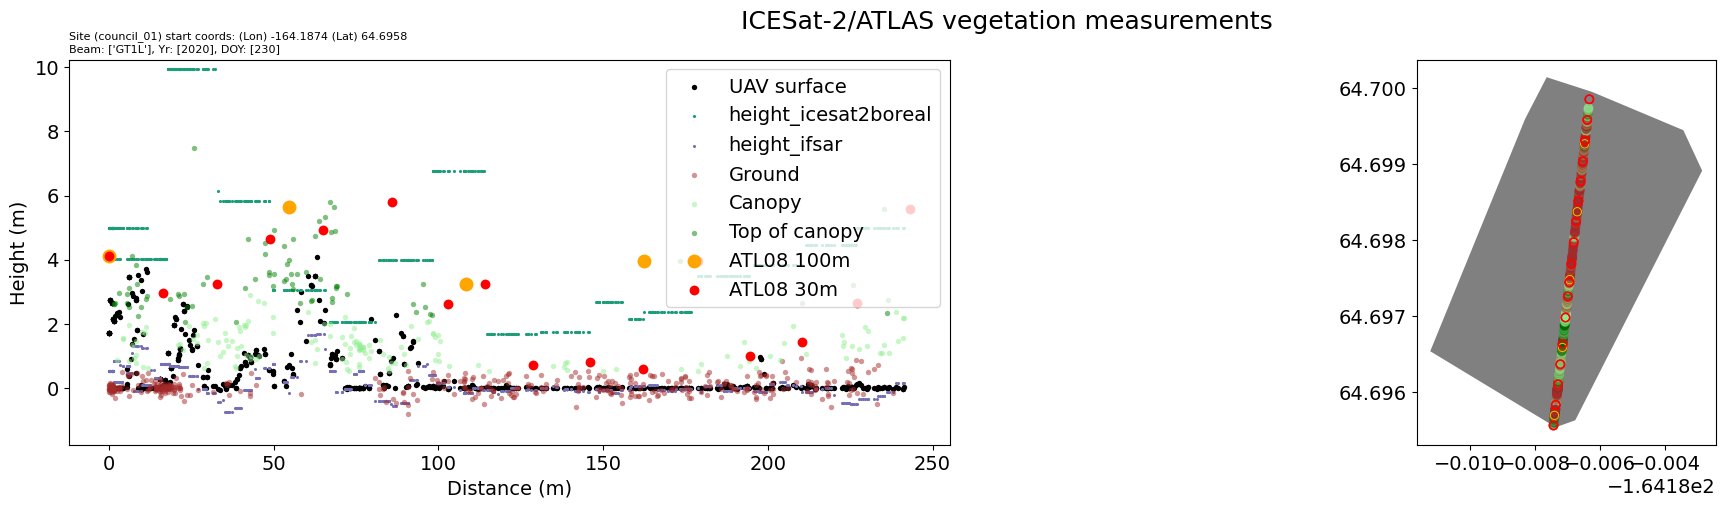

In [262]:
for site in reversed(atl03_field_gdf_extract.site.unique()):
    print(site)
    # Remove rows where dsm values are NA
    #atl03_TMP = atl03_field_gdf[atl03_field_gdf.dsm_uav != -10000]
    plotlib.plot_atl03_transect(start=0, transect_length=50000, DO_HEIGHT=True, 
                                atl03_gdf=atl03_field_gdf_extract[(atl03_field_gdf_extract.site == site) & (atl03_field_gdf_extract.dsm_uav != -10000)], 
                                atl08_100m_gdf=atl08_field_gdf_extract[(atl08_field_gdf_extract.site == site) ],#& (atl08_field_gdf_extract.dsm_uav != -10000)], 
                                atl08_30m_gdf=atl08_30m_field_gdf_extract[(atl08_30m_field_gdf_extract.site == site) ],#& (atl08_30m_field_gdf_extract.dsm_uav != -10000)], 
                                footprint_uav_gdf=footprint_uav_gdf[footprint_uav_gdf.site == site],
                               site=site, PLOT_UAV=True, HEIGHT_COLS = ['height_icesat2boreal','height_ifsar'])

council_02


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



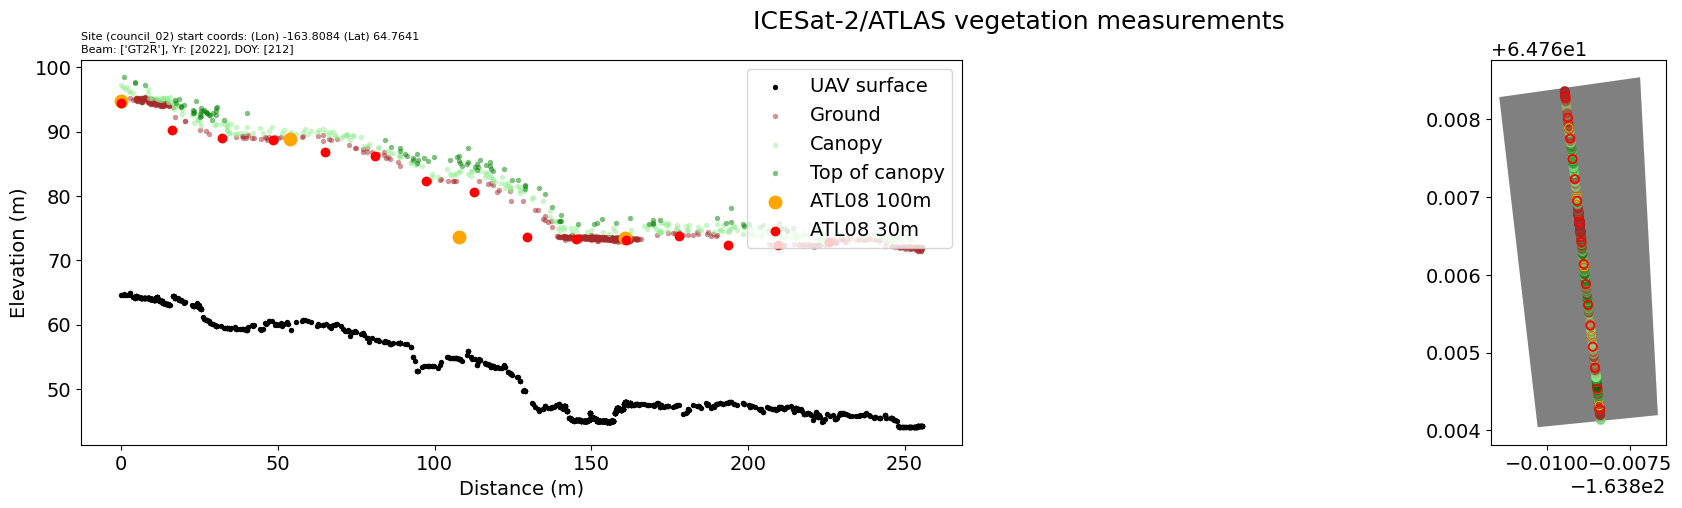

kougarok_02


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



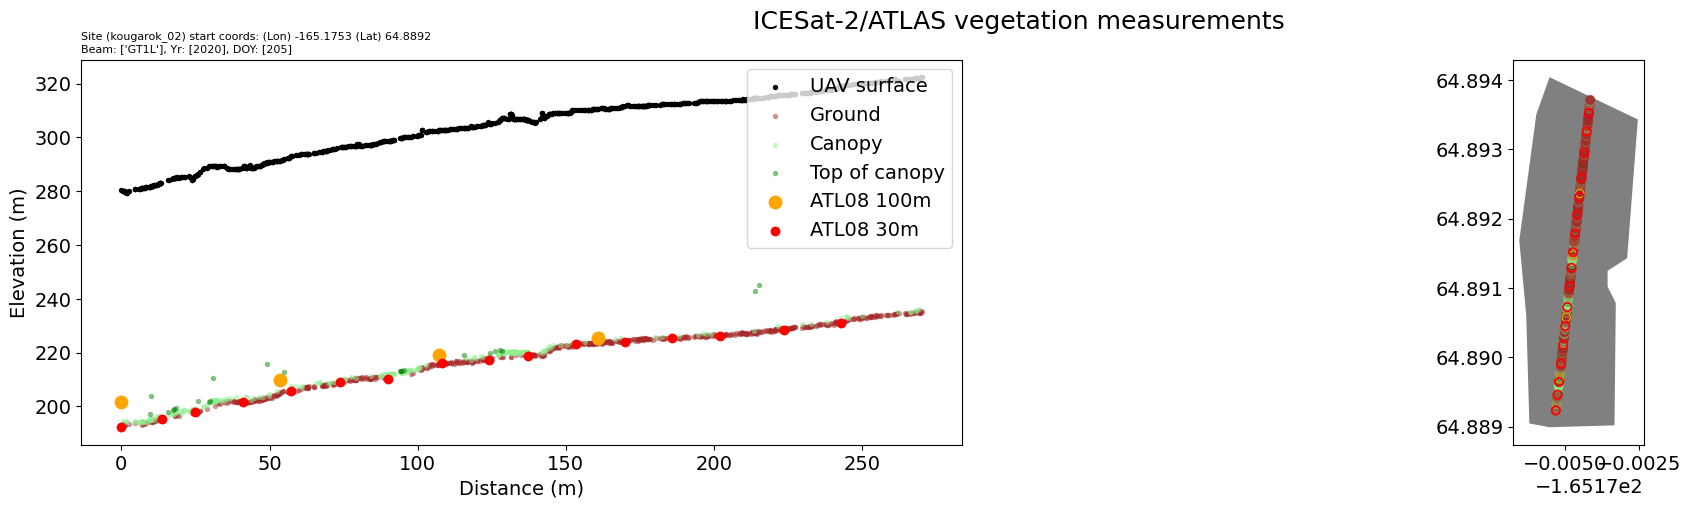

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



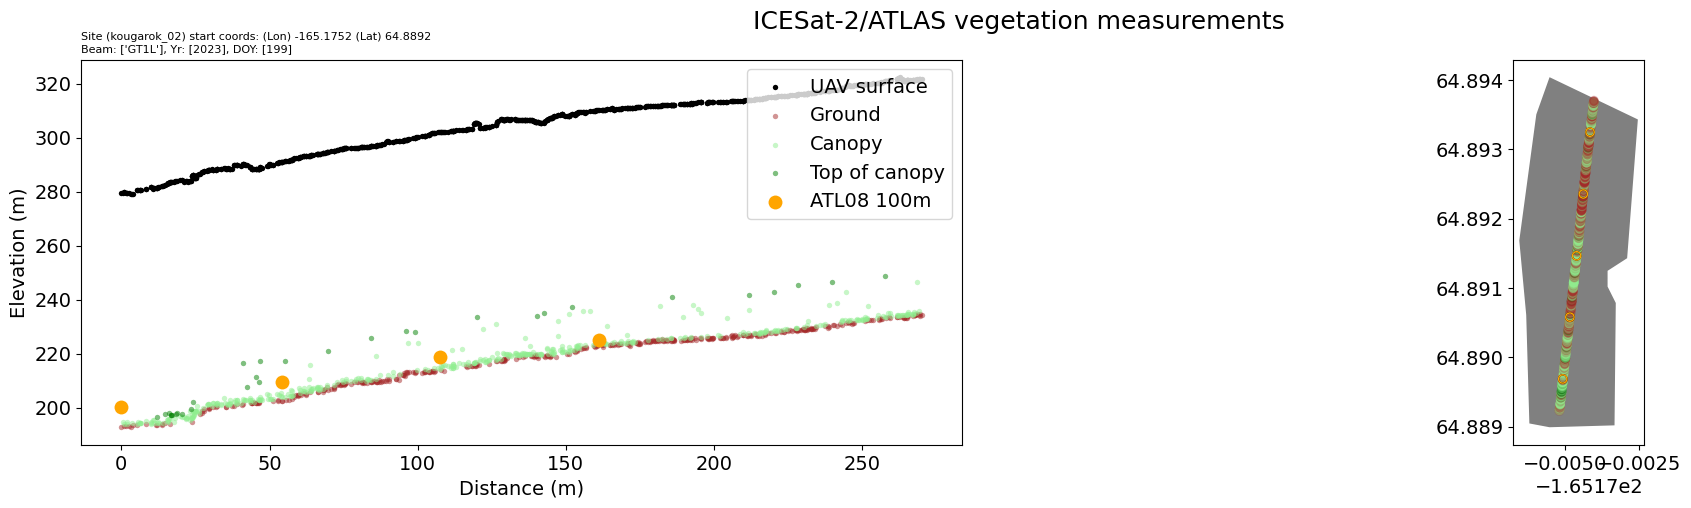

kougarok_04


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



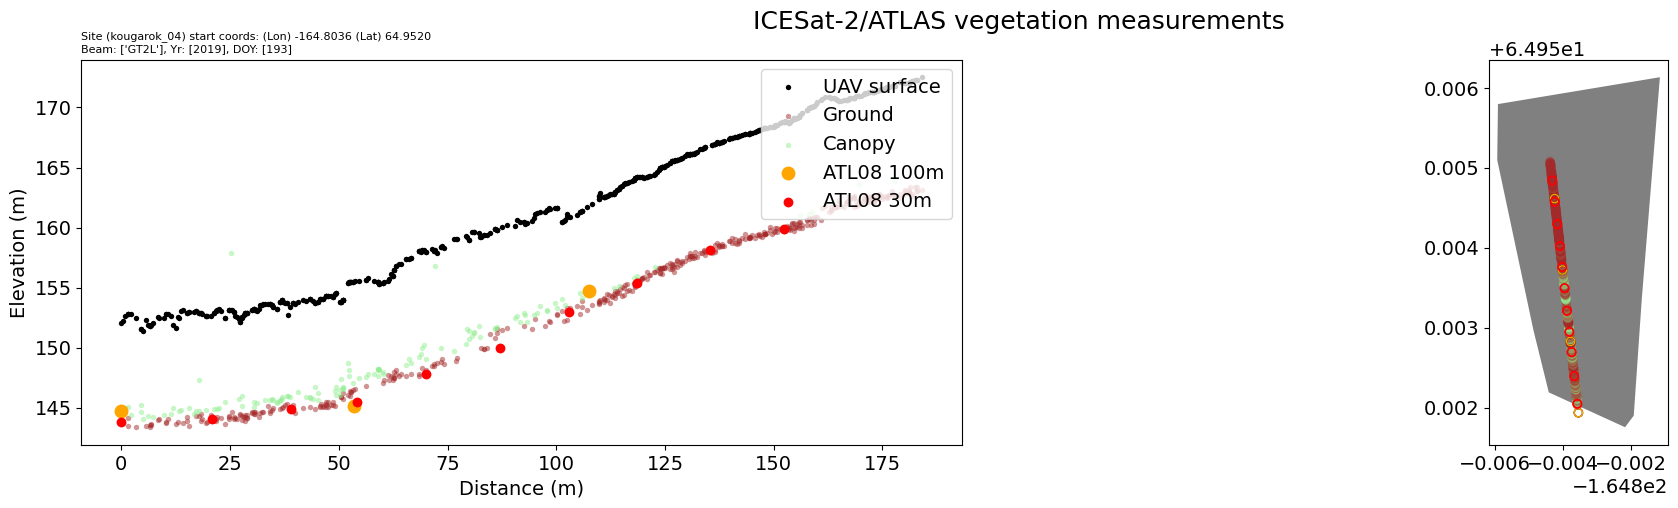

kougarok_06


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



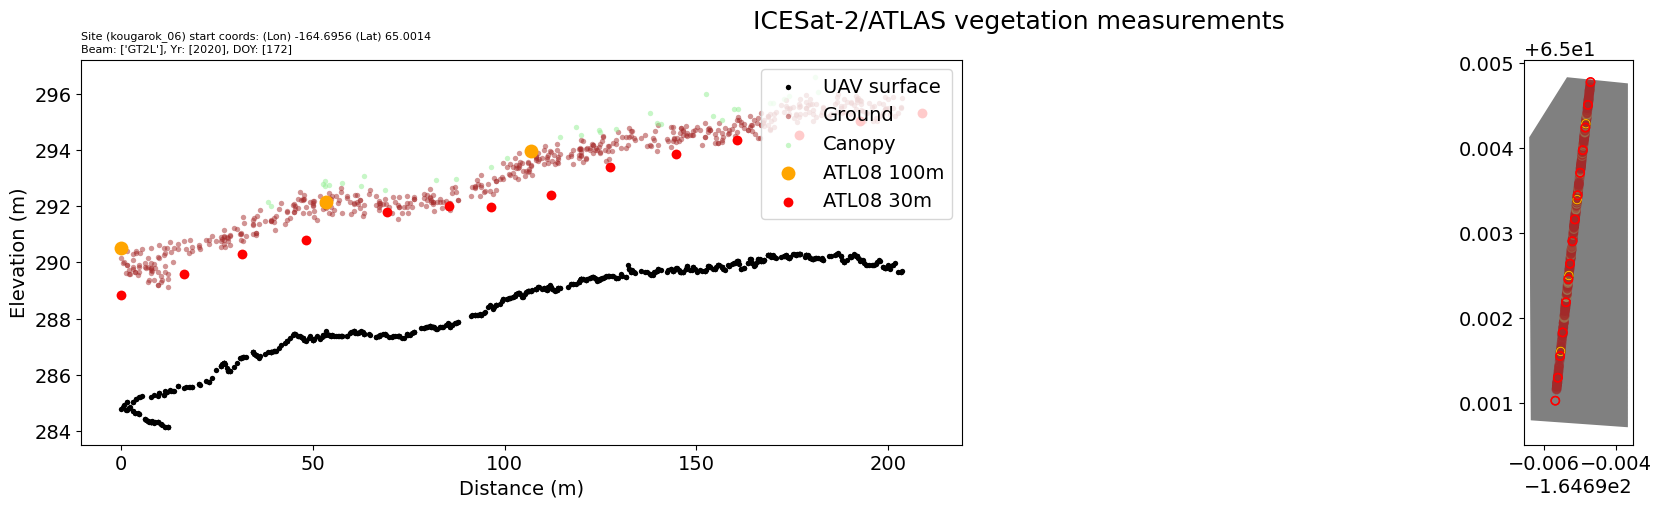

kougarok_01


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



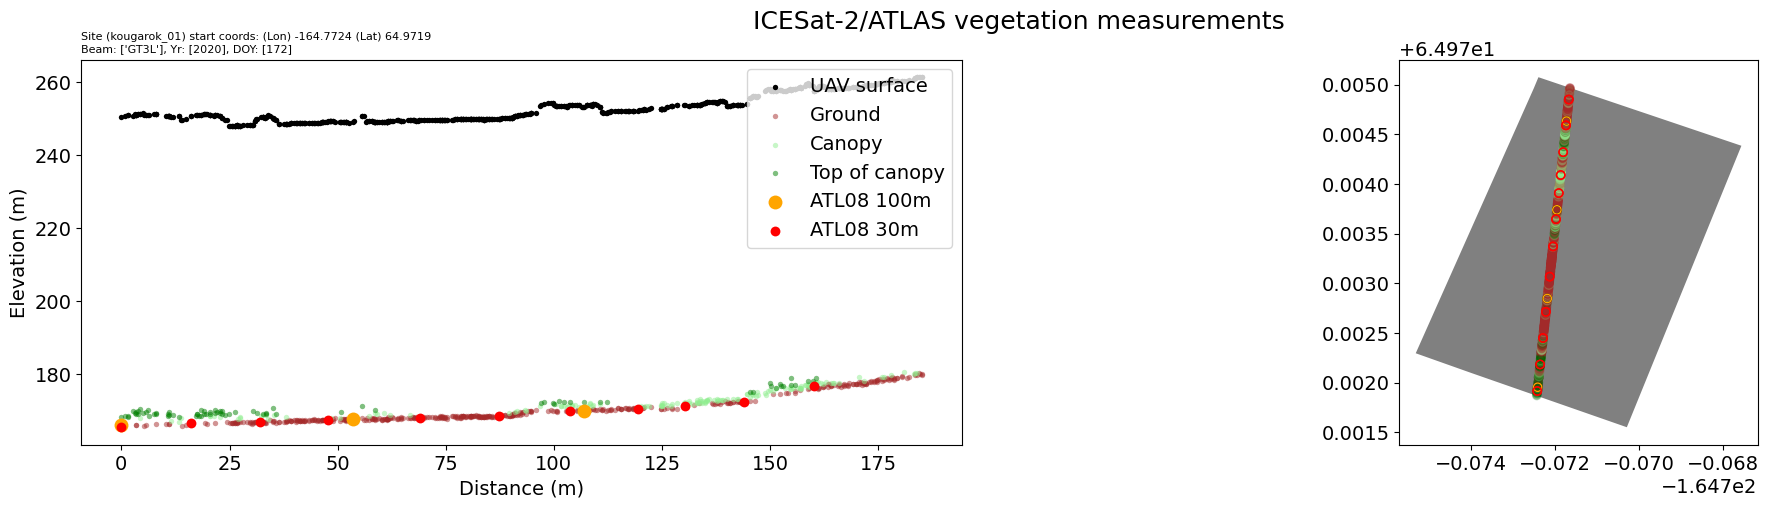

kougarok_05


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



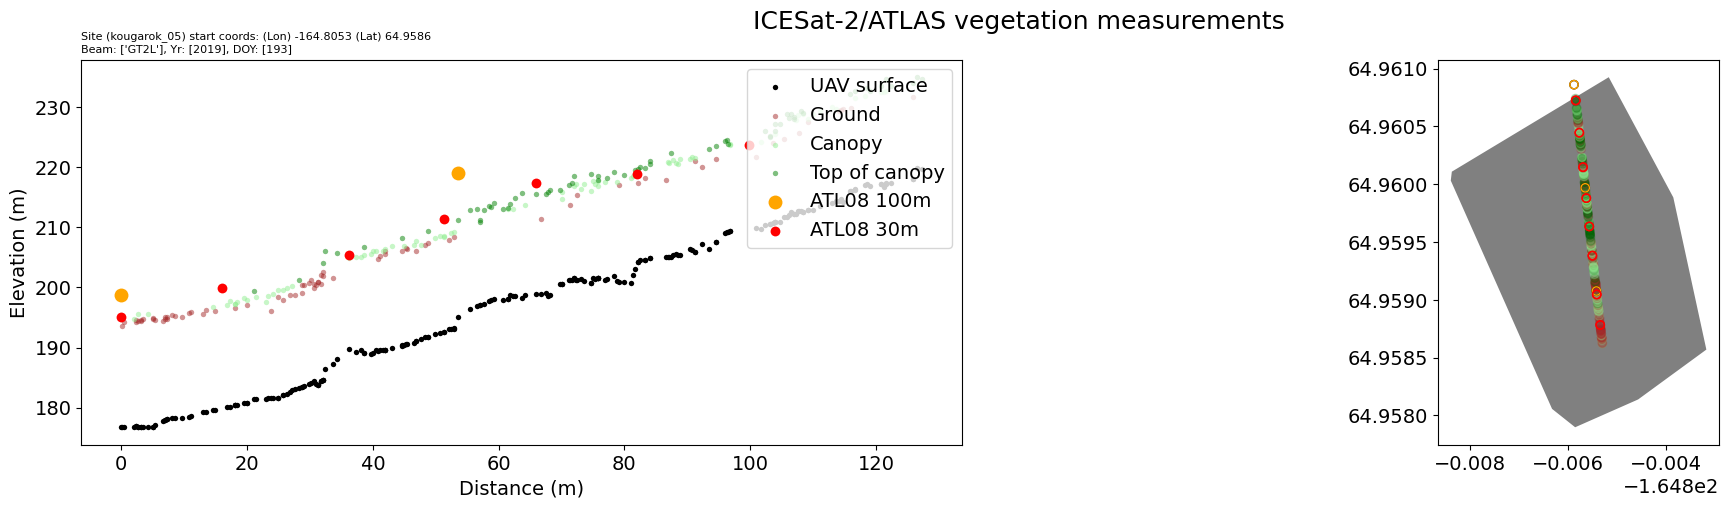

kougarok_03


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



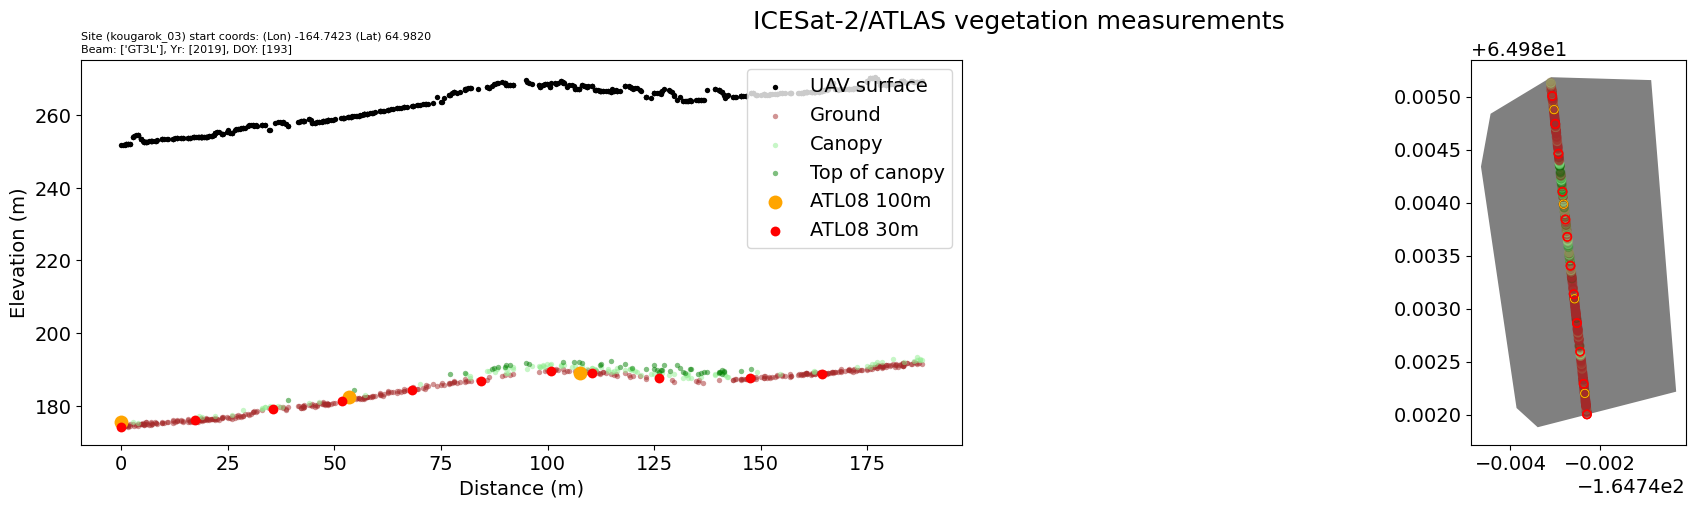

teller_01


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



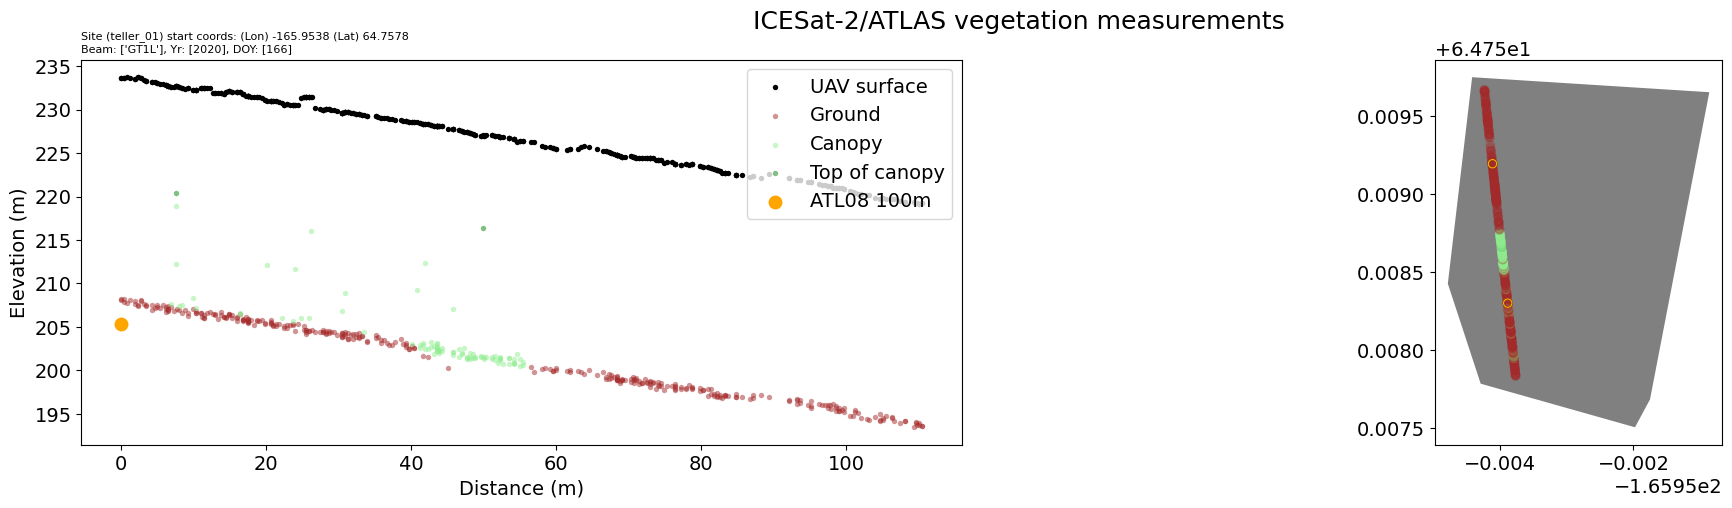

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



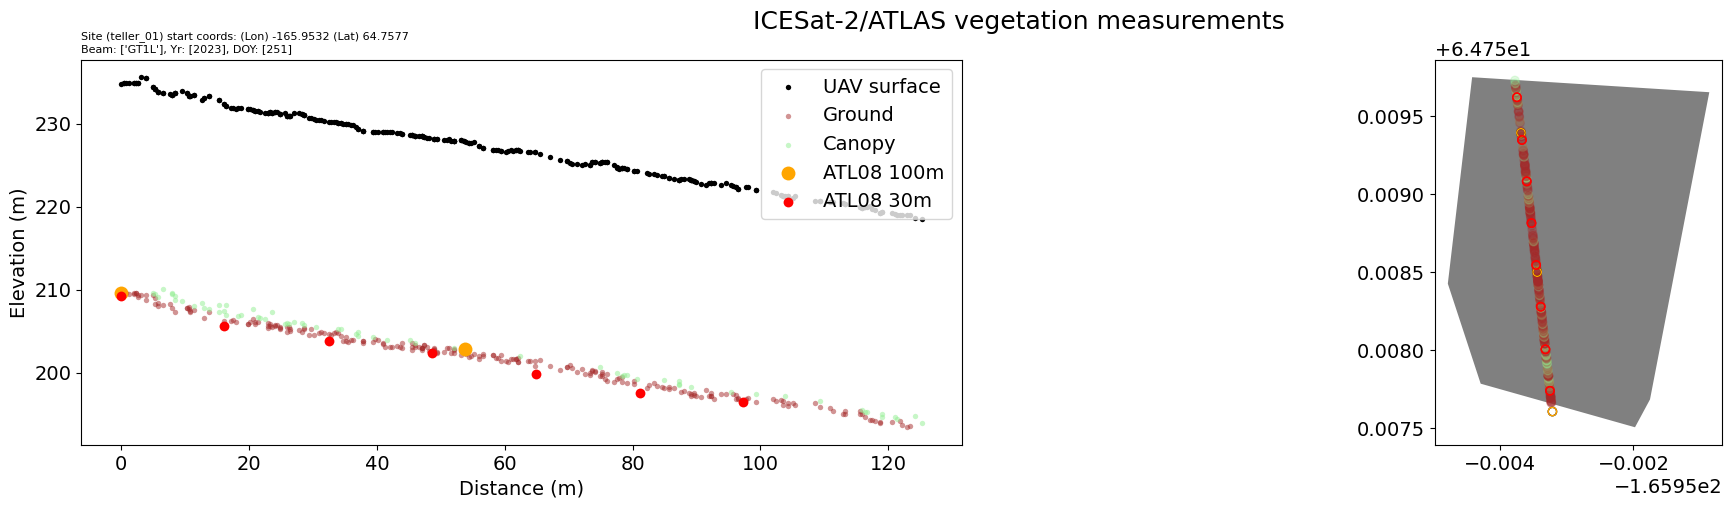

council_01


/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



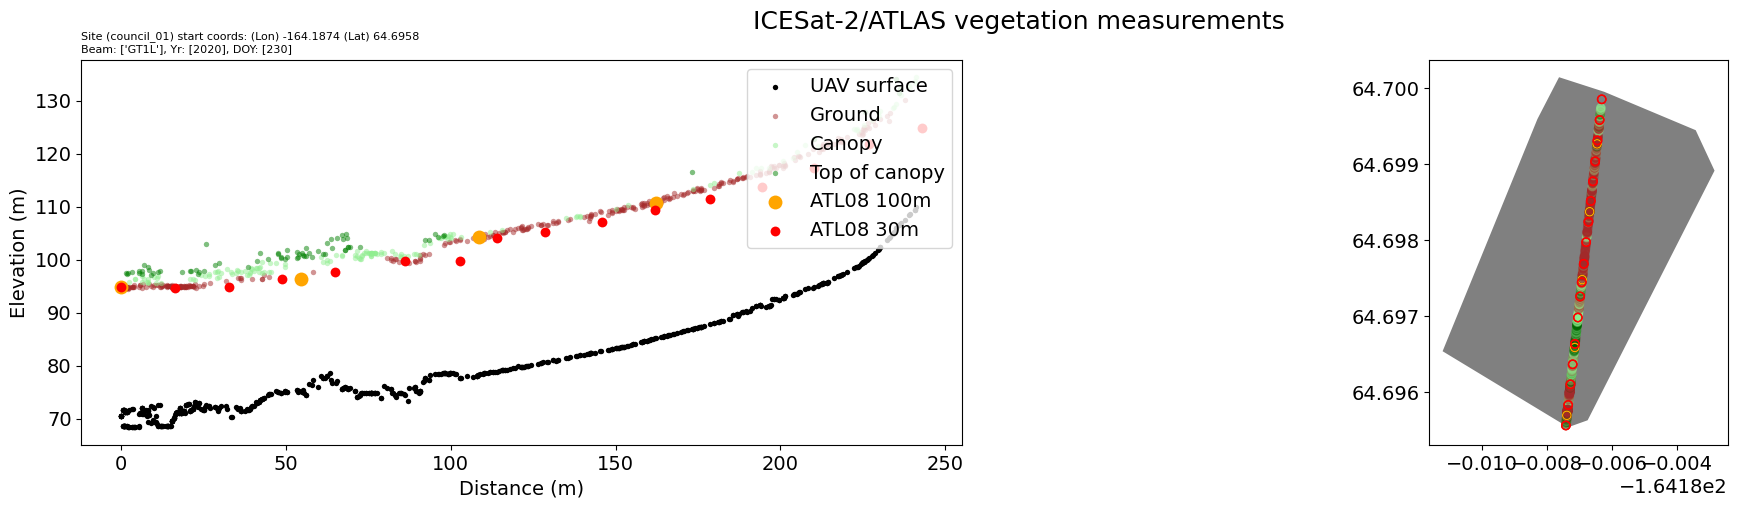

In [263]:
for site in reversed(atl03_field_gdf.site.unique()):
    print(site)
    # Remove rows where dsm values are NA
    #atl03_TMP = atl03_field_gdf[atl03_field_gdf.dsm_uav != -10000]
    plotlib.plot_atl03_transect(start=0, transect_length=50000, DO_HEIGHT=False, 
                                atl03_gdf=atl03_field_gdf_extract[(atl03_field_gdf_extract.site == site) & (atl03_field_gdf_extract.dsm_uav != -10000)], 
                                atl08_100m_gdf=atl08_field_gdf_extract[(atl08_field_gdf_extract.site == site) ],#& (atl08_field_gdf_extract.dsm_uav != -10000)], 
                                atl08_30m_gdf=atl08_30m_field_gdf_extract[(atl08_30m_field_gdf_extract.site == site) ],#& (atl08_30m_field_gdf_extract.dsm_uav != -10000)], 
                                footprint_uav_gdf=footprint_uav_gdf[footprint_uav_gdf.site == site],
                               site=site, PLOT_UAV=True)

In [62]:
import sys
sys.path.append('/home/pmontesa/code')
import maplib
import folium
import numpy

In [73]:
footprint_uav_gdf = gpd.read_file('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/footprints_uav_sewardpen2024_RGB_COG.gpkg').drop('date', axis=1)

In [59]:
import importlib
importlib.reload(maplib)
from folium import plugins

In [79]:
m_atl03 = maplib.ADD_ATL03_OBS_TO_MAP(atl03_field_gdf[atl03_field_gdf['class'] > 0].drop('datetime', axis=1), footprint_uav_gdf.explore() )

In [27]:
#m_atl03